# The Neurobiological Basis of Interpersonal Neural Synchronization: <br>Evidence from a Multimodal Data Fusion Approach

This notebook guides through the majority of analyses reported in our meta-analysis and quantitative review of interpersonal neural synchrony (INS) fMRI and fNIRS studies. The main analyses rely on the [Neuroimaging Meta-Analysis Research Environment (NiMARE) 0.0.11](https://nimare.readthedocs.io/) and were performed in a Python 3.8.8 environment on a macOS 12.3.1 system. Custom functions are located in `/src`, see [README](README.md). Resting-state functional connectivity analyses and spatial correlations were conducted separately in a MATLAB (2021a) environment. For description of output files, see [data README](data/README.md).

**Dependencies:**  
See [poetry.lock](poetry.loc) file. Uses the matlab-python engine which is easiest installed by running `python setup.py install` in a terminal from `{matlabroot}/extern/engines/python`. Requires Matlab with Parallel Processing toolbox, [JuSpace](https://github.com/juryxy/JuSpace), [ABAnnotate](https://github.com/LeonDLotter/ABAnnotate), and [SPM12](https://www.fil.ion.ucl.ac.uk/spm/software/spm12/).

**Table of Content:**  

In [2]:
from src.ipynb_toc import make_ipynb_toc
make_ipynb_toc('./MAsync_analyses.ipynb')

- [The Neurobiological Basis of Interpersonal Neural Synchronization: <br>Evidence from a Multimodal Data Fusion Approach](#The-Neurobiological-Basis-of-Interpersonal-Neural-Synchronization:-<br>Evidence-from-a-Multimodal-Data-Fusion-Approach)
    - [0.1 Modules and base variables](#0.1-Modules-and-base-variables)
    - [0.2 NiMARE datasets](#0.2-NiMARE-datasets)
  - [1 Primary activation likelihood estimation of fMRI studies](#1-Primary-activation-likelihood-estimation-of-fMRI-studies)
    - [1.1 Run ALE](#1.1-Run-ALE)
    - [1.2 Repeat ALE with more lenient thresholding](#1.2-Repeat-ALE-with-more-lenient-thresholding)
    - [1.3 Repeat ALE excluding pseudo-hyperscanning studies](#1.3-Repeat-ALE-excluding-pseudo-hyperscanning-studies)
    - [1.4 Prepare volumes for following analyses](#1.4-Prepare-volumes-for-following-analyses)
  - [2 Validation of ALE findings](#2-Validation-of-ALE-findings)
    - [2.1 Leave one experiment out](#2.1-Leave-one-experiment-out)
    - [2.2 Contribution of single experiments](#2.2-Contribution-of-single-experiments)
    - [2.3 Robustness against publication bias](#2.3-Robustness-against-publication-bias)
  - [3 Quantitative analysis of fNIRS hyperscanning experiments](#3-Quantitative-analysis-of-fNIRS-hyperscanning-experiments)
    - [3.1 Descriptive quantitative evaluation of fNIRS data](#3.1-Descriptive-quantitative-evaluation-of-fNIRS-data)
    - [3.2 Perform ALE on fMRI and fNIRS data](#3.2-Perform-ALE-on-fMRI-and-fNIRS-data)
      - [3.2.1 Contribution of single experiments](#3.2.1-Contribution-of-single-experiments)
    - [3.3 fNIRS sensitivity analyses](#3.3-fNIRS-sensitivity-analyses)
      - [3.3.1 Repeat fNIRS evaluation restricted to studies explicitly assessing interaction > no interaction contrasts](#3.3.1-Repeat-fNIRS-evaluation-restricted-to-studies-explicitly-assessing-interaction->-no-interaction-contrasts)
      - [3.3.2 Repeat fNIRS-fMRI-ALE with randomized fNIRS coordinates](#3.3.2-Repeat-fNIRS-fMRI-ALE-with-randomized-fNIRS-coordinates)
  - [4 Task-related and task-free connectivity](#4-Task-related-and-task-free-connectivity)
    - [4.1 Meta-analytic connectivity modelling](#4.1-Meta-analytic-connectivity-modelling)
      - [4.1.1 Run MACM](#4.1.1-Run-MACM)
      - [4.1.2 Prepare volumes for following analyses and plot](#4.1.2-Prepare-volumes-for-following-analyses-and-plot)
      - [4.1.3 Spatial correlation between ALE and MACM maps](#4.1.3-Spatial-correlation-between-ALE-and-MACM-maps)
      - [4.1.4 Baseline adjusted meta-analytic connectivity modelling](#4.1.4-Baseline-adjusted-meta-analytic-connectivity-modelling)
    - [4.2 Resting-state functional connectivity](#4.2-Resting-state-functional-connectivity)
  - [5 Meta-analytic contextualization](#5-Meta-analytic-contextualization)
    - [5.1 Neurosynth topics](#5.1-Neurosynth-topics)
      - [5.1.1 ROI-based neurosynth topic associations](#5.1.1-ROI-based-neurosynth-topic-associations)
      - [5.1.2 Whole-brain-based neurosynth topic associations](#5.1.2-Whole-brain-based-neurosynth-topic-associations)
    - [5.2 Social interaction & theory of mind](#5.2-Social-interaction-&-theory-of-mind)
      - [5.2.1 Social interaction: Feng et al., 2021](#5.2.1-Social-interaction:-Feng-et-al.,-2021)
      - [5.2.2 Theory of mind: Schurz et al., 2021](#5.2.2-Theory-of-mind:-Schurz-et-al.,-2021)
    - [5.3 Resting-state networks](#5.3-Resting-state-networks)
    - [5.4 TPJ subunits](#5.4-TPJ-subunits)
  - [6 Molecular and genetic contextualization](#6-Molecular-and-genetic-contextualization)
    - [6.1 Associations to neurotransmitter receptors & gene expression](#6.1-Associations-to-neurotransmitter-receptors-&-gene-expression)
    - [6.2 Gene-category enrichment analyses](#6.2-Gene-category-enrichment-analyses)
      - [6.2.1 GCEA on neuronal cell types](#6.2.1-GCEA-on-neuronal-cell-types)
      - [6.2.2 GCEA on developmental brain regional expression data](#6.2.2-GCEA-on-developmental-brain-regional-expression-data)
      - [6.2.3 GCEA on disease-related genetic markers](#6.2.3-GCEA-on-disease-related-genetic-markers)
      - [6.2.4 GCEA on GeneOntology data](#6.2.4-GCEA-on-GeneOntology-data)
    - [6.3 Validation analyses for the INS-GABAa association](#6.3-Validation-analyses-for-the-INS-GABAa-association)
  - [7 Finished!](#7-Finished!)

### 0.1 Modules and base variables

In [25]:
# libraries
from os.path import join, abspath, dirname, split
from glob import glob
import scipy as sp
import scipy.cluster.hierarchy as spc 
import numpy as np
import pandas as pd
import matlab.engine
import matplotlib.pyplot as plt
from seaborn import regplot, clustermap, heatmap
from abagen import get_expression_data
from statsmodels.stats.multitest import fdrcorrection
from nilearn.image import load_img, math_img, index_img, iter_img
from nilearn.plotting import plot_connectome
from nilearn.glm import threshold_stats_img
from nimare.dataset import Dataset
from nimare.decode.discrete import BrainMapDecoder
from nimare.meta.cbma.ale import ALE, SCALE
from IPython.display import display, Markdown
from tqdm.auto import tqdm

# custom meta-analysis & co scripts
from src.ale import ale
from src.loeo import loeo, contributions
from src.fsn import fsn
from src.overlap import rel_abs_distributions
from src.fnirs import fnirs_result, rand_nimare_coords
from src.neurosynth import download_neurosynth, create_neurosynth_topic_maps 

# custom helper functions
from src.utils_io import csv_to_nimare_ds, fnirs_to_nimare_dataset
from src.utils_plot import plot_gb, plot_surf
from src.utils_image import get_size_of_rois, correlate_volumes_via_atlas, parcel_data_to_volume

# working directory
cp = abspath('MAsync_main.ipynb')
wd = join(dirname(cp), 'data')

# NiMARE ALE settings
n_perm = 5000 # run N = 5000 permutations
v_thr = 0.001 # voxel-level threshold p < 0.001
n_core = 4 # '-1' for all CPU cores

# Parcellation atlases used throughout the analyses (Schaefer 2018 - 100 cortical parcels + Tian 2021 16 subcortical)
atlas100 = load_img(join(wd, 'atlases', 'Schaefer100-7_2mm.nii.gz'))
atlas116 = load_img(join(wd, 'atlases', 'Schaefer100-7_TianS1_2mm.nii.gz'))

### 0.2 NiMARE datasets

In [26]:
## 1. INS fMRI studies
# If multiple contrasts per study are given, concatenate data into one experiment.
ds = csv_to_nimare_ds(file   =join(wd, 'datasets', 'fmri_coordinates.csv'), # spreadsheed with study info
                      exp_var='publication', # column indicating experiment names
                      n_var  ='n', # column indicating sample sizes
                      con_var='contrasts', # column indicating contrast names
                      spa_var='space', # column indicating coordinate space
                      x_var  ='x', y_var='y', z_var='z', # columns indicating coordinates
                      single_contrasts=False) # concatenate contrasts per experiment

## 2. INS fNIRS studies
# spreadsheet with fnirs results
fnirs_df = pd.read_csv(join(wd, 'datasets', 'fnirs_coordinates.csv'))
fnirs_df_sel = fnirs_df[fnirs_df.selected==1]
# load studies into nimare dataset
ds_fnirs = fnirs_to_nimare_dataset(fnirs_df, False)
ds_fnirs_sel = fnirs_to_nimare_dataset(fnirs_df_sel, False)

## 2. BrainMap database ("Normal Mapping" AND "Activations only")
# downloaded via Sleuth 3.0.4 on 24th Jan 2022 and converted to NiMARE database
ds_brainmap = Dataset.load(join(wd, 'datasets', 'brainmap_NormMapActOnly_2022-01-24.pkl.gz'))

## 3. Neurosynth database
# Use this code to download neurosynth database, requires biopython, will skip if already downloaded
ds_neurosynth = download_neurosynth(save_path=join(wd, 'datasets', 'neurosynth'), version=7, abstract=False, 
                                    email='leondlotter@gmail.com', vocab='LDA200', overwrite=False)

INFO: Converting TAL coordinates from Silbert 2014 to MNI.
INFO: Converting TAL coordinates from Stephens 2010 to MNI.
INFO: Converting TAL coordinates from Wang 2021 to MNI.
INFO: Concatenating coordinates over multiple contrasts per study.
INFO: Imported data from 22 studies, 740 participants, and 313 foci as 22 unique contrasts into NiMARE dataset.
INFO: Importing 68 fNIRS experiments.
INFO: Concatenating coordinates over multiple contrasts per study.
INFO: Imported data from 59 studies, 3429.0 participants, and 224 foci as 59 unique contrasts into NiMARE dataset.
INFO: Importing 55 fNIRS experiments.
INFO: Concatenating coordinates over multiple contrasts per study.
INFO: Imported data from 46 studies, 2137.0 participants, and 174 foci as 46 unique contrasts into NiMARE dataset.
INFO: Downloading Neurosynth database...


File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.


INFO: Loading existing NiMARE dataset from /Users/leonlotter/MAsync/project/data/datasets/neurosynth/neurosynth_dataset.pkl.gz


File exists and overwrite is False. Skipping.
[{'coordinates': '/Users/leonlotter/MAsync/project/data/datasets/neurosynth/neurosynth/data-neurosynth_version-7_coordinates.tsv.gz',
  'features': [{'features': '/Users/leonlotter/MAsync/project/data/datasets/neurosynth/neurosynth/data-neurosynth_version-7_vocab-LDA200_source-abstract_type-weight_features.npz',
                'keys': '/Users/leonlotter/MAsync/project/data/datasets/neurosynth/neurosynth/data-neurosynth_version-7_vocab-LDA200_keys.tsv',
                'metadata': '/Users/leonlotter/MAsync/project/data/datasets/neurosynth/neurosynth/data-neurosynth_version-7_vocab-LDA200_metadata.json',
                'vocabulary': '/Users/leonlotter/MAsync/project/data/datasets/neurosynth/neurosynth/data-neurosynth_version-7_vocab-LDA200_vocabulary.txt'}],
  'metadata': '/Users/leonlotter/MAsync/project/data/datasets/neurosynth/neurosynth/data-neurosynth_version-7_metadata.tsv.gz'}]


INFO: Finished. Returning NiMARE dataset


Dataset(14371 experiments, space='mni152_2mm')


## 1 Primary activation likelihood estimation of fMRI studies

The main ALE analysis in this study. We included coordinates from all fMRI studies that assessed interpersonal neural synchrony using correlational approaches and reported coordinates in standardized 3D space.

Extracted coordinates are stored in a csv file and read into a NiMARE database. Coordinates reported in Talairach space are transformed to MNI space using the Lancaster-transform as implemented in NiMARE ([Lancaster et al., 2007](http://doi.org/10.1002/hbm.20345)). 
The function to calculate ALEs ([Turkeltaub et al. 2002](https://doi.org/10.1006/nimg.2002.1131), [2012](https://doi.org/10.1002/hbm.21186), [Eickhoff et al., 2012](https://doi.org/10.1016/j.neuroimage.2011.09.017)) takes a NiMARE database or a Sleuth text-file as input and follows the [NiMARE ALE workflow](https://github.com/neurostuff/nimare/blob/b5082c8/nimare/workflows/ale.py#L16). Activation maps for each experiment are modeled in MNI152 space at 2mm isotropic resolution. As recommended ([Eickhoff et al., 2016](https://doi.org/10.1016/j.neuroimage.2016.04.072)), the ALE map is thresholded at p < .001 (uncorrected) at voxel-level and p < .05 (FWE-corrected) at cluster-level. Cluster-significance is determined by comparison of resulting cluster masses with a null-distribution of maximum cluster masses generated by random relocation of foci within a gray matter template. NiMARE logp-, z- and ALE-maps as well as thresholded & binarized volumes, and cluster information tables are stored. The cluster corrected maps output by NiMARE were thresholded at one-sided p < 0.05 (equaling logp > 1.3 or z > 1.65 for logp or z maps, respectively).

Results indicate two clusters showing meta-analytic consistency across included studies located (1) at posterior superior/medial temporal gyrus, often considered as a part of the right temporoparietal junction (rTPJ), and (2) at the right anterior superior temporal gyrus (rSTG). Using a more lenient voxel-level threshold, these clusters gain in size and a third cluster located at the right insula emerge. The rTPJ cluster remains robust when excluding studies using "pseudo"-hyperscanning (then N = 15).

### 1.1 Run ALE

INFO:src.ale:Calculating ALE on 22 experiments with 22 contrasts, 740 subjects and 313 foci.
INFO:src.ale:Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, based on cluster mass with 5000 permutations.


The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
  0%|          | 0/5000 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
100%|██████████| 5000/5000 [26:10<00:00,  3.18it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
INFO:src.ale:ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/project/data/ale



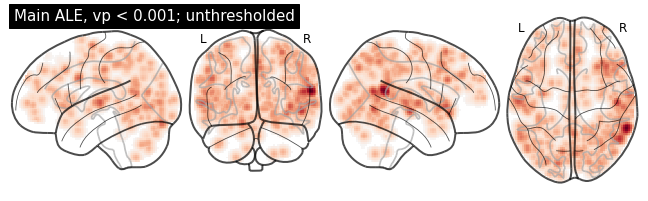

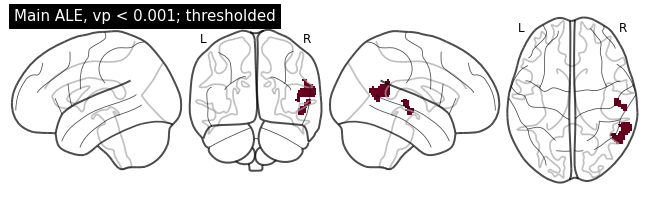

In [ ]:
_ = ale(data    =ds, # NiMARE dataset
        work_dir=join(wd, 'ale'), pref='ale_', # path and prefix of stored files
        vox_thr =v_thr, # voxel-level threshold
        cluster ='mass', # cluster inference based on cluster mass
        n_perm  =n_perm, # number of iterations for FWE correction
        n_core  =n_core, # number of computing cores to use
        glassbrain_title='Main ALE, vp < 0.001') # title of results plot

### 1.2 Repeat ALE with more lenient thresholding

We repeat the ALE analysis with a more lenient voxel-threshold of p < .01 to increase sensitivity for potential weak effects.

INFO:src.ale:Calculating ALE on 22 experiments with 22 contrasts, 740 subjects and 313 foci.
INFO:src.ale:Thresholding: voxel-level p < 0.01 uncorrected, cluster-level p < 0.05 FWE-corrected, based on cluster mass with 5000 permutations.
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
  0%|          | 0/5000 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
100%|██████████| 5000/5000 [21:43<00:00,  3.84it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
INFO:src.ale:ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/project/data/ale



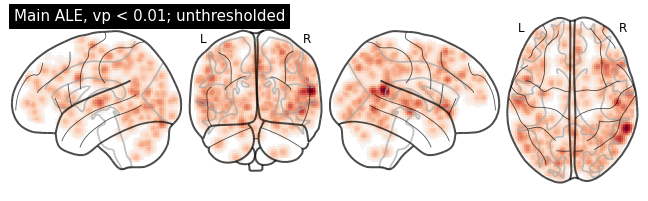

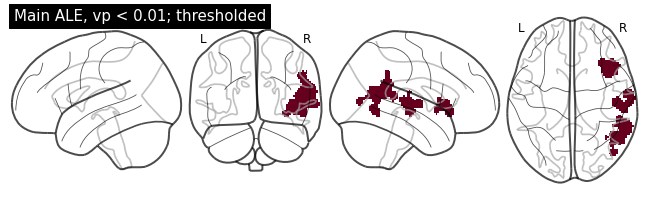

In [ ]:
_ = ale(data=ds, work_dir=join(wd, 'ale'), pref='ale01_', vox_thr=0.01, cluster='mass',
        n_perm=n_perm, n_core=n_core, glassbrain_title='Main ALE, vp < 0.01')

### 1.3 Repeat ALE excluding pseudo-hyperscanning studies

N(hyperscanning) = 15, N(pseudo-hyperscanning) = 7


INFO:src.ale:Calculating ALE on 15 experiments with 15 contrasts, 610 subjects and 189 foci.
INFO:src.ale:Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, based on cluster mass with 5000 permutations.


The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
  0%|          | 0/5000 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
100%|██████████| 5000/5000 [13:49<00:00,  6.03it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
INFO:src.ale:ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/project/data/ale



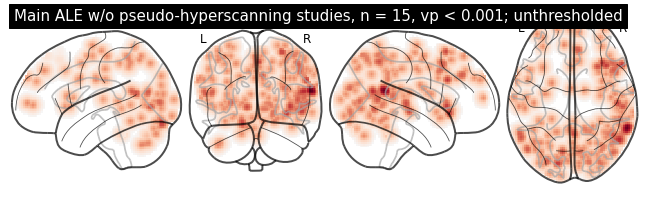

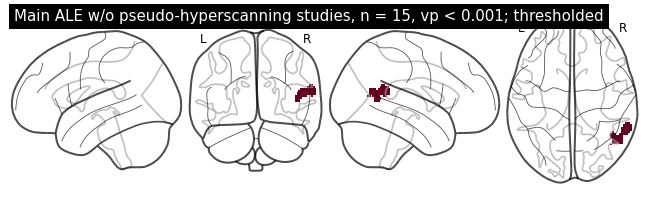

In [ ]:
# get ids of "real" hyperscanning experiments
ds_ids = ds.ids
ds_ids_pseudo, ds_ids_real = list(), list()
for id in ds_ids:
    if 'pseudo' in id: ds_ids_pseudo.append(id)
    else: ds_ids_real.append(id)
print(f'N(hyperscanning) = {len(ds_ids_real)}, N(pseudo-hyperscanning) = {len(ds_ids_pseudo)}')

# new dataset
ds_nopseudo = ds.slice(ds_ids_real)

# run ALE
_ = ale(data=ds_nopseudo, work_dir=join(wd, 'ale'), pref='aleNoPseudo_', vox_thr=v_thr,  cluster='mass',
        n_perm=n_perm, n_core=n_core, 
        glassbrain_title=f'Main ALE w/o pseudo-hyperscanning studies, n = {len(ds_ids_real)}, vp < 0.001')

### 1.4 Prepare volumes for following analyses

In [27]:
# z-scored unthresholded ALE-map
ale_z = load_img(join(wd, 'ale', 'ale_z.nii.gz'))
# binarized thresholded ALE map
ale_bin = load_img(join(wd, 'ale', 'ale_thresh_bin.nii.gz'))
# binarized rTPJ-cluster, vp < .001
ale_rTPJ_bin = index_img(join(wd, 'ale', 'ale_thresh_4d.nii.gz'), 0)
# binarized rSTG-cluster, vp < .001
ale_rSTG_bin = index_img(join(wd, 'ale', 'ale_thresh_4d.nii.gz'), 1)

## 2 Validation of ALE findings

### 2.1 Leave one experiment out

We control our findings for the influence of single experiments or studies by systematically rerunning the main ALE analysis while excluding one experiment at a time (LOEO). To evaluate the results, we calculate the conjunction between all binary cluster maps resulting from the LOEO ALEs. Conjunction maps are calculated by simple element-wise multiplication of the thresholded and binarized 3D volumes ([Nichols et al, 2005](https://doi.org/10.1016/j.neuroimage.2004.12.005)).

Only the rTPJ cluster proofed stable against the influence of single experiments.

INFO:src.loeo:
Calculate ALE without experiment: 1 Anders 2011-pseudo: predict perciever's from sender's activity
INFO:src.ale:Calculating ALE on 21 experiments with 21 contrasts, 728 subjects and 306 foci.
INFO:src.ale:Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, based on cluster mass with 5000 permutations.
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
  0%|          | 0/5000 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
100%|██████████| 5000/5000 [15:47<00:00,  5.27it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
INFO:src.ale:ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/project/data/loeo

INFO:src.loeo:
Calculate AL

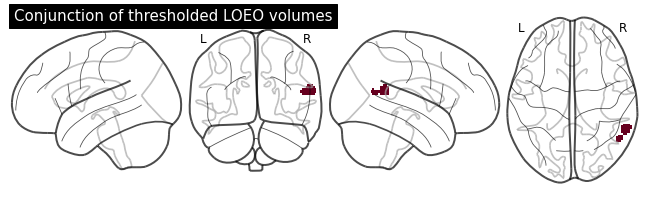

In [ ]:
# Custom function performing N(experiments) ALEs, while leaving out one experiment at a time.
# voxel-level p < 0.001
loeo_res, _ = loeo(ds=ds, v_thr=v_thr, n_perm=n_perm, n_core=n_core, # ALE settings
                   save_dir=join(wd, 'loeo'), prefix='loeo_', # path and prefix for stored files
                   conj_save=join(wd, 'loeo', 'loeo_conjunction.nii.gz')) # path for stored conjunction volume

INFO:src.loeo:
Calculate ALE without experiment: 1 Anders 2011-pseudo: predict perciever's from sender's activity
INFO:src.ale:Calculating ALE on 21 experiments with 21 contrasts, 728 subjects and 306 foci.
INFO:src.ale:Thresholding: voxel-level p < 0.01 uncorrected, cluster-level p < 0.05 FWE-corrected, based on cluster mass with 5000 permutations.
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
  0%|          | 0/5000 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
100%|██████████| 5000/5000 [21:20<00:00,  3.90it/s]
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
INFO:src.ale:ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/project/data/loeo

INFO:src.loeo:
Calculate ALE

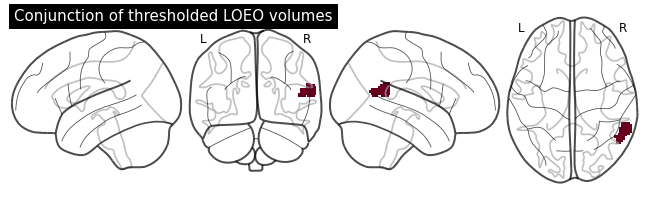

In [ ]:
# voxel-level p < 0.01
loeo01_res, _ = loeo(ds=ds, v_thr=0.01, n_perm=n_perm, n_core=n_core,
                   save_dir=join(wd, 'loeo'), prefix='loeo01_', 
                   conj_save=join(wd, 'loeo', 'loeo01_conjunction.nii.gz'))

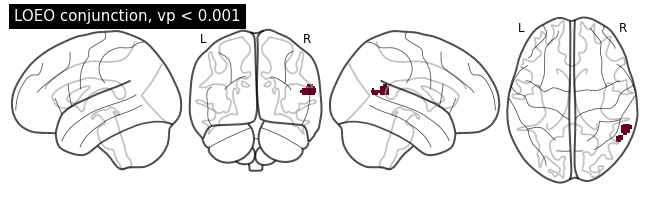

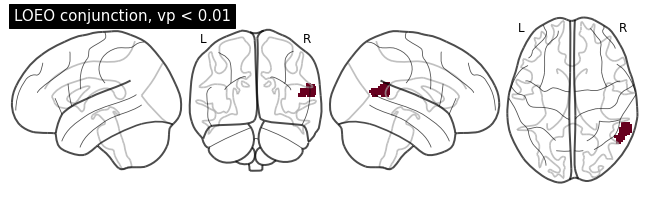

In [ ]:
# Plot LOEO conjunction volume
plot_gb(join(wd, 'loeo', 'loeo_conjunction.nii.gz'), title='LOEO conjunction, vp < 0.001')
plot_gb(join(wd, 'loeo', 'loeo01_conjunction.nii.gz'), title='LOEO conjunction, vp < 0.01')

### 2.2 Contribution of single experiments

Following Eickhoff et al. ([2016](https://doi.org/10.1016/j.neuroimage.2016.04.072)), we assess the average contribution of each experiment to the resulting ALE clusters based on the LOEO ALEs. For each experiment, we calculate the ratio of the averaged ALE values within the clusters with and without the current experiment.

Results show that 12 of 22 experiments (\~55%) contributed relevantly to the rTPJ cluster with a maximum contribution of \~16%.

In [ ]:
# custom function to calculate experiment-wise contributions (in percent) to a given cluster
# voxel-level p < 0.001
ale_contributions = contributions(
    ale_ALL =join(wd, 'ale', 'ale_stat.nii.gz'), # ALE value volume, all experiments included
    ale_EXP =[join(wd, 'loeo', f'loeo_{i+1}_stat.nii.gz') for i in range(len(ds.ids))], # list of ALE value volumes from LOEO analyses
    cl_masks=[ale_rTPJ_bin, ale_rSTG_bin], # binarized cluster(s)
    exp_ids =ds.ids) # list of experiment IDs
ale_contributions.to_csv(join(wd, 'loeo', 'loeo_contributions.csv'), float_format='%f', index=False) # save table

# custom function to calculate experiment-wise contributions (in percent) to a given cluster
# voxel-level p < 0.01
ale01_contributions = contributions(
    ale_ALL =join(wd, 'ale', 'ale01_stat.nii.gz'), 
    ale_EXP =[join(wd, 'loeo', f'loeo01_{i+1}_stat.nii.gz') for i in range(len(ds.ids))],
    cl_masks=[index_img(join(wd, 'ale', 'ale01_thresh_4d.nii.gz'), i) for i in range(3)],
    exp_ids =ds.ids) 
ale01_contributions.to_csv(join(wd, 'loeo', 'loeo01_contributions.csv'), float_format='%f', index=False) # save table

# print results for vp < 0.001
n_contributed = len(ale_contributions[ale_contributions['cl1_contr_prc'] > 0.5]) # nr of contributing studies
print(f'{n_contributed}/{len(ale_contributions)} studies contributed to the rTPJ cluster more then .5 % (vp < 0.001).')
display(ale_contributions.sort_values(by='cl1_contr_prc', ascending=False).head(n_contributed)) # print table
# print results for vp < 0.01
n_contributed = len(ale_contributions[ale_contributions['cl1_contr_prc'] > 0.5]) # nr of contributing studies
print(f'{n_contributed}/{len(ale_contributions)} studies contributed to the rTPJ cluster more then .5 % (vp < 0.01).')
display(ale01_contributions.sort_values(by='cl1_contr_prc', ascending=False).head(n_contributed)) # print table

INFO:src.loeo:Calculated experiment-wise contributions of 22 experiments to 2 clusters.
INFO:src.loeo:Calculated experiment-wise contributions of 22 experiments to 3 clusters.


12/22 studies contributed to the rTPJ cluster more then .5 % (vp < 0.001).


ID  cl1_exp_sum  \
17  Spilakova 2020-dyad-ISC during cooperation > r...     0.016312   
4   Koike 2016 1 3 + 2019b-2016 1 dyad-ISC during ...     0.016952   
14  Silbert 2014-pseudo: speaker/listener-ISC > ra...     0.017373   
2   Bilek 2015 2-(dyad-ISC during interaction > no...     0.017615   
7   Kostorz 2020-pseudo: intructor-observer-ISC ac...     0.017686   
16  Spiegelhalder 2014-dyad-ISC during speak/liste...     0.017771   
18  Stephens 2010-pseudo: speaker-listener-ISC > l...     0.017781   
13   Shaw 2020-dyad-ISC during coop/comp > random-ISC     0.017904   
1   Bilek 2015 1-(dyad-ISC during interaction > no...     0.018324   
20  Xie 2020-dyad-ISC during collaborative drawing...     0.018447   
21  Yoshioka 2021-task-dependent dyad-ISC during J...     0.018742   
5   Koike 2016 2-dyad-ISC during mutual gaze witho...     0.018935   

    cl1_all_sum  cl1_contr_prc  cl2_exp_sum  cl2_all_sum  cl2_contr_prc  
17     0.019418      15.992473     0.012928     0.016553      21.897491  
4      0.019418      12.699213     0.016552     0.016553       0.003694  
14     0.019418      10.527254     0.016498     0.016553       0.331036  
2      0.019418       9.282396     0.016553     0.016553       0.000000  
7      0.019418       8.917800     0.016553     0.016553       0.000000  
16     0.019418       8.480579     0.016444     0.016553       0.654737  
18     0.019418       8.427356     0.016550     0.016553       0.012664  
13     0.019418       7.794962     0.013166     0.016553      20.459273  
1      0.019418       5.632402     0.016553     0.016553       0.000000  
20     0.019418       4.998588     0.016551     0.016553       0.010282  
21     0.019418       3.476642     0.014097     0.016553      14.836369  
5      0.019418       2.485389     0.016553     0.016553       0.000000

12/22 studies contributed to the rTPJ cluster more then .5 % (vp < 0.01).


ID  cl1_exp_sum  \
4   Koike 2016 1 3 + 2019b-2016 1 dyad-ISC during ...     0.012272   
21  Yoshioka 2021-task-dependent dyad-ISC during J...     0.012414   
7   Kostorz 2020-pseudo: intructor-observer-ISC ac...     0.012624   
17  Spilakova 2020-dyad-ISC during cooperation > r...     0.012715   
14  Silbert 2014-pseudo: speaker/listener-ISC > ra...     0.012756   
20  Xie 2020-dyad-ISC during collaborative drawing...     0.012814   
18  Stephens 2010-pseudo: speaker-listener-ISC > l...     0.013237   
2   Bilek 2015 2-(dyad-ISC during interaction > no...     0.013341   
16  Spiegelhalder 2014-dyad-ISC during speak/liste...     0.013379   
13   Shaw 2020-dyad-ISC during coop/comp > random-ISC     0.013426   
1   Bilek 2015 1-(dyad-ISC during interaction > no...     0.013563   
5   Koike 2016 2-dyad-ISC during mutual gaze witho...     0.013654   

    cl1_all_sum  cl1_contr_prc  cl2_exp_sum  cl2_all_sum  cl2_contr_prc  \
4      0.014141      13.220166     0.012303     0.012307       0.032895   
21     0.014141      12.214360     0.010924     0.012307      11.238437   
7      0.014141      10.726745     0.012307     0.012307       0.000061   
17     0.014141      10.085893     0.010969     0.012307      10.873340   
14     0.014141       9.797097     0.011291     0.012307       8.255332   
20     0.014141       9.387480     0.012296     0.012307       0.089687   
18     0.014141       6.392534     0.011316     0.012307       8.050933   
2      0.014141       5.659829     0.012307     0.012307       0.000000   
16     0.014141       5.386384     0.012131     0.012307       1.431073   
13     0.014141       5.057441     0.011087     0.012307       9.916141   
1      0.014141       4.084907     0.012307     0.012307       0.000000   
5      0.014141       3.443847     0.012307     0.012307       0.000000   

    cl3_exp_sum  cl3_all_sum  cl3_contr_prc  
4      0.010350     0.011676      11.354190  
21     0.007659     0.011676      34.403727  
7      0.011676     0.011676       0.000179  
17     0.011676     0.011676       0.000000  
14     0.010102     0.011676      13.477965  
20     0.011676     0.011676       0.000000  
18     0.010257     0.011676      12.154432  
2      0.011676     0.011676       0.000000  
16     0.011676     0.011676       0.000000  
13     0.011676     0.011676       0.000000  
1      0.011676     0.011676       0.000000  
5      0.011676     0.011676       0.000000

### 2.3 Robustness against publication bias

[Acar et al. (2018)](https://doi.org/10.1371/journal.pone.0208177) proposed a method to assess ALE results for the influence of the "file drawer effect" by adding a number of noise experiments to the original sets of coordinates and evaluating their influence on a certain significant cluster. Properties of noise studies (sample-sizes, number of coordinates) are drawn from the "true" dataset. Noise foci are sampled outside of the brain quadrant where the "true" clusters (rTPJ, rSTG) are located to reduce the chance of noise foci contributing to the clusters. The FSN is approximated by iteratively testing the inclusion of low and high numbers of noise studies starting at predefined points ("fsn_range") that we determined from the number of contributing studies (12 and 98, the latter would result in a minimum contribution of 12/(98+22) = 10% of studies when noise studies are included).

Results show a FSN of 66 for the rTPJ cluster, meaning that up to approximately 66 experiments reporting coordinates in different brain locations can be added to the ALE analysis before the rTPJ cluster looses significance. For the rSTG cluster, the FSN was below the defined minimum of 12 additional studies. Considering the very low chance that more than 66 INS fMRI studies would "remain in the file drawer", this result indicates robustness of the rTPJ finding against publication bias.

In [ ]:
# custom python implementation of the FSN-method by Acar et al. Only results volumes of the final run are stored.
# warning regarding "pixdim" (fetching of template for MNI coordinate sampling) has no influence on result 
fsn_tab, _, ds_noise = fsn(ds       =ds, # 'true' NiMARE dataset
                           cl_true  =[ale_rTPJ_bin, ale_rSTG_bin], # true clusters to check on 
                           fsn_range=[12, 98], # starting points to search for exact FSN
                           save_dir =join(wd, 'fsn'), 
                           pref     ='fsn_', # path and prefix for stored files
                           n_perm   =n_perm, 
                           v_thr    =v_thr, 
                           cluster  ='mass', # ALE settings
                           seed     =987654321) # seed to make noise study generation reproducible

INFO: Cluster 1:

INFO: Generating noise studies while excluding cluster brain quadrant.
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x
INFO: FSN step 1: Add minimum 12 noise studies.

INFO: Calculating ALE on 34 experiments with 34 contrasts, 1109 subjects and 497 foci.
INFO: Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, based on cluster mass with 5000 permutations.
  0%|          | 0/5000 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
100%|██████████| 5000/5000 [24:55<00:00,  3.34it/s]
INFO: ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/project/dat

cluster appr_fsn min_fsn max_fsn
0     cl1       66      66      66
1     cl2     < 12    < 12    < 12

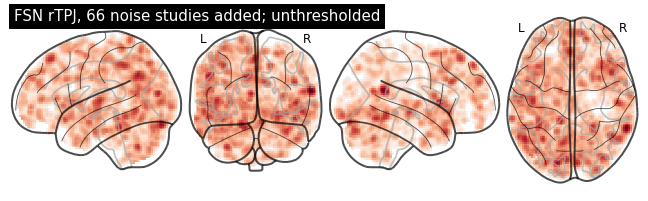

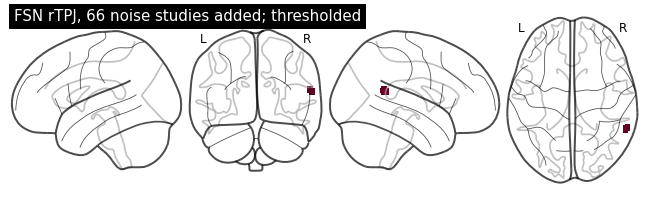

In [ ]:
# show and save result and plot rTPJ volumes with FSN noise studies added
fsn_tab.to_csv(join(wd, 'fsn', 'fsn_result.csv'), index=False) # save table
ds_noise.save(join(wd, 'fsn', 'ds_noise_studies.pkl.gz')) # save noise dataset
plot_gb(join(wd, 'fsn', 'fsn_cl1_z.nii.gz'), # print unthresholded volume
        title='FSN rTPJ, {} noise studies added; unthresholded'.format(fsn_tab.appr_fsn[0]))
plot_gb(join(wd, 'fsn', 'fsn_cl1_thresh_bin.nii.gz'), # print thresholded volume
        title='FSN rTPJ, {} noise studies added; thresholded'.format(fsn_tab.appr_fsn[0]))
fsn_tab.head() # print results

## 3 Quantitative analysis of fNIRS hyperscanning experiments

For fNIRS studies, no standardized results reporting system and no meta-analytic analyses techniques exist. To approximate a meta-analytic evaluation of fNIRS INS findings, we:  
1. reconstruct the positioning of fNIRS probe sets as applied in each study using [AtlasViewer](https://openfnirs.org/software/homer/)  
2. extract the MNI coordinates corresponding to each fNIRS channel  
3. use a whole-brain atlas to summarize the fNIRS data ROI-wise: For each atlas parcel, we extract the number of channels showing INS, the overall number of channels, and associated study information.

By using of a relatively coarse parcellation, we make sure not to overestimate the spatial resolution of fNIRS data, especially considering the added spatial uncertainty due to post-hoc reconstruction of channel coordinates without detailed information on head shape, size and probe positioning.  

68 fNIRS experiments were included in this analysis. INS results show mainly frontal, and secondary right temporoparietal locations.

### 3.1 Descriptive quantitative evaluation of fNIRS data

INFO: Loaded fNIRS data, kept 1929 rows with coordinate information from 68 experiments.
INFO: Finding nearest atlas region for each coordinate. Maximum distance = 4.12.
INFO: Extracting parcel-wise results...
INFO: Creating volumes...
INFO: Finished.


region  n_chan_sync  n_chan_all  chan_sync/all  \
12             LH_Default_PFC_2         11.0          56           0.20   
34        RH_Default_PFCdPFCm_2         17.0         114           0.15   
31             LH_Default_PFC_4         21.0         113           0.19   
35               RH_Cont_PFCl_3         12.0          87           0.14   
27  RH_SalVentAttn_TempOccPar_1          5.0          35           0.14   
45        RH_Default_PFCdPFCm_1          6.0          38           0.16   
17                RH_Cont_Par_2          9.0          64           0.14   
46                     RH_Vis_3          4.0          19           0.21   
24               RH_Cont_PFCl_2          7.0          63           0.11   
0                LH_Cont_PFCl_1          8.0          62           0.13   

    chan_sync/all*sub_all  
12                 441.00  
34                 422.70  
31                 398.62  
35                 385.84  
27                 300.30  
45                 295.04  
17                 282.10  
46                 281.19  
24                 279.95  
0                  265.33

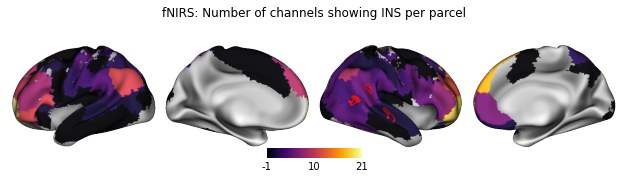

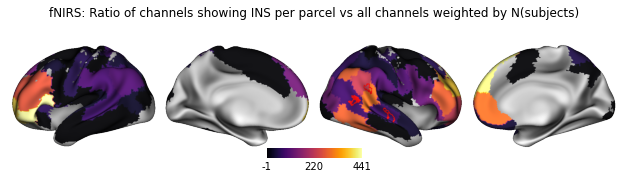

In [28]:
# get fnirs results
fnirs_res, fnirs_vols, fnirs_coord = fnirs_result(
    data  =fnirs_df, # table with results, column names are fixed (see script)
    atlas =atlas100, # atlas, Schaefer 100 cortical parcels 
    labels=pd.read_csv(join(wd, 'atlases', 'Schaefer100-7_2mm.csv'))) # parcel labels with fixed columns names 'idx' & 'label'

# save
fnirs_res.to_csv(join(wd, 'fnirs', 'fnirs_atlas_result.csv'), index=False)
fnirs_coord.to_csv(join(wd, 'fnirs', 'fnirs_coordinates_nearest.csv'), index=False)
fnirs_vols['sync'].to_filename(join(wd, 'fnirs', 'fnirs_atlas_syncChannels.nii.gz'))
fnirs_vols['ratio'].to_filename(join(wd, 'fnirs', 'fnirs_atlas_ratioSyncAllChannels.nii.gz'))
fnirs_vols['ratio_weighted'].to_filename(join(wd, 'fnirs', 'fnirs_atlas_ratioSyncAllChannelsSubj.nii.gz'))

# show result
display(fnirs_res[['region', 'n_chan_sync', 'n_chan_all', 'chan_sync/all', 'chan_sync/all*sub_all']].head(10))

# plot on fsLR surface
plot_surf(fnirs_vols['sync'], title='fNIRS: Number of channels showing INS per parcel',
          overlay=ale_bin, interp='nearest', cmap='inferno')
plot_surf(fnirs_vols['ratio_weighted'], title='fNIRS: Ratio of channels showing INS per parcel vs all channels weighted by N(subjects)',
          overlay=ale_bin, interp='nearest', cmap='inferno')

### 3.2 Perform ALE on fMRI and fNIRS data

Secondary, we perform an explorative ALE on combined fMRI and fNIRS data. Note, that this is clearly to be considered explorative as the ALE method is not designed for use with fNIRS data, nor generally with data not covering the whole brain. To reduce overestimation of the spatial precision of fNIRS data, we convolve all fNIRS coordinates with a FWHM = 10mm Gaussian distribution, independent of the actual sample size. From 68 fNIRS experiments, 59 reported at least one significant INS coordinate, resulting in 81 (22 + 59) combined fNIRS+fMRI experiments.

From this analysis, three frontal clusters emerge in addition to the remaining rTPJ cluster. The fNIRS-driven clusters are located in the bilateral superior frontal gyri and in the right middle frontal gyrus.

In [8]:
# set fnirs sample sizes to n = 10 (corresponding to 10mm FWHM)
ds_fnirs.metadata.sample_sizes = [[10]] * len(ds_fnirs.metadata)
# merge datasets
ds_fmri_fnirs = ds.merge(ds_fnirs)

INFO: Calculating ALE on 81 experiments with 81 contrasts, 1330 subjects and 537 foci.
INFO: Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, based on cluster mass with 5000 permutations.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO: ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/project/data/ale



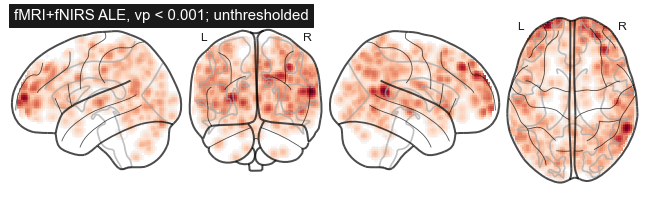

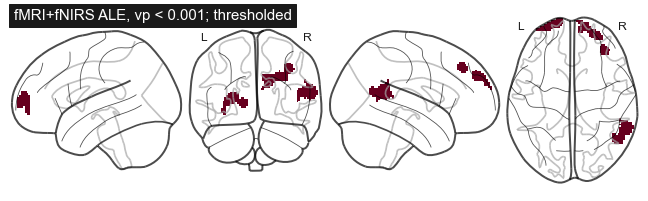

In [9]:
# run ale
_ = ale(data=ds_fmri_fnirs, work_dir=join(wd, 'ale'), pref='aleFNIRS_', vox_thr=0.001, cluster='mass',
        n_perm=n_perm, n_core=n_core, glassbrain_title='fMRI+fNIRS ALE, vp < 0.001')

#### 3.2.1 Contribution of single experiments

Like for the fMRI ALE, we assess the contribution of single experiments to the combined fMRI+fNIRS ALE. This time, we only estimate the unthresholded ALE maps excluding one experiment at a time without performing cluster correction.

In [10]:
# get experiment ids
exps_ds_fmri_fnirs = ds_fmri_fnirs.ids
# get ALE estimator
fit_ale = ALE()

# iterate over experiments
loeoFNIRS = list()
for i, exp in enumerate(exps_ds_fmri_fnirs):
    print(f'Calculate ALE without experiment: {i+1} {exp}')

    # remove current experiment from ds
    ds_x = ds_fmri_fnirs.slice(np.delete(exps_ds_fmri_fnirs, i))
    # estimate map
    ale_x = fit_ale.fit(ds_x)
    ale_map = ale_x.get_map('stat')
    # save map
    loeoFNIRS.append(ale_map)

# calculate contribution to fMRI-fNIRS ALE clusters
aleFNIRS_contributions = contributions(
    ale_ALL =join(wd, 'ale', 'aleFNIRS_stat.nii.gz'), # ALE value volume, all experiments included
    ale_EXP =loeoFNIRS , # list of ALE value volumes from fNIRS LOEO analyses
    cl_masks=[img for img in iter_img(join(wd, 'ale', 'aleFNIRS_thresh_4d.nii.gz'))], # binarized clusters
    exp_ids =exps_ds_fmri_fnirs) # list of experiment IDs
aleFNIRS_contributions.to_csv(join(wd, 'fnirs', 'fnirs_ale_contributions.csv'), float_format='%f', index=False) # save table

Calculate ALE without experiment: 1 Anders 2011-pseudo: predict perciever's from sender's activity
Calculate ALE without experiment: 2 Balconi 2017-ISC post pos feedback > ISC pre pos feedback
Calculate ALE without experiment: 3 Balconi 2018-ISC pre neg feedback/ control > ISC post neg feedback
Calculate ALE without experiment: 4 Balconi 2019-ISC after material gift </> ISC after experiential gift
Calculate ALE without experiment: 5 Bilek 2015 1-(dyad-ISC during interaction > no interaction) > random-ISC
Calculate ALE without experiment: 6 Bilek 2015 2-(dyad-ISC during interaction > no interaction) > random-ISC
Calculate ALE without experiment: 7 Canigueral 2021-prediction of partner's ISC from rTPJ during shared > private conditions
Calculate ALE without experiment: 8 Chen 2020 1-female dyad ISC during deception > rest
Calculate ALE without experiment: 9 Chen 2020 2-male dyad ISC during deception > rest
Calculate ALE without experiment: 10 Cheng 2015-ISC synchronize > press faster/ re

INFO: Calculated experiment-wise contributions of 81 experiments to 4 clusters.


### 3.3 fNIRS sensitivity analyses

#### 3.3.1 Repeat fNIRS evaluation restricted to studies explicitly assessing interaction > no interaction contrasts

In this analysis, we restrict fNIRS studies to those explicitly contrasting interaction conditions vs rest or control conditions, or randomization. I.e., excluding experiments assessing for example INS "pre- vs post-social feedback" or "video-based vs in-person-learning".

The results, now including 55 fNIRS and 68 combined fNIRS+fMRI experiments, indicate general correspondence to the analyses including all fNIRS data.

INFO: Loaded fNIRS data, kept 1583 rows with coordinate information from 55 experiments.
INFO: Finding nearest atlas region for each coordinate. Maximum distance = 4.12.
INFO: Extracting parcel-wise results...
INFO: Creating volumes...
INFO: Finished.


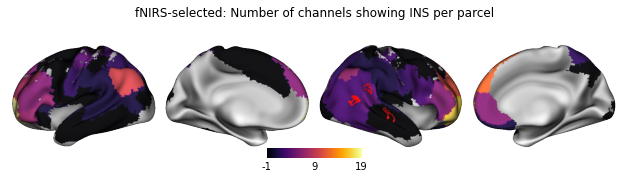

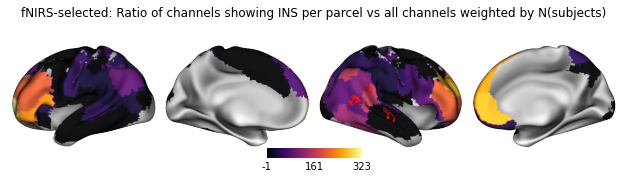

In [29]:
## DESCRIPTIVE QUANTITATIVE EVALUATION

# get fnirs results
fnirs_res_sel, fnirs_vols_sel, fnirs_coord_sel = fnirs_result(
    data  =fnirs_df_sel,
    atlas =atlas100, 
    labels=pd.read_csv(join(wd, 'atlases', 'Schaefer100-7_2mm.csv'))) 

# save
fnirs_res_sel.to_csv(join(wd, 'fnirs', 'fnirs_atlas_result_sel.csv'), index=False)
fnirs_coord_sel.to_csv(join(wd, 'fnirs', 'fnirs_coordinates_nearest_sel.csv'), index=False)
fnirs_vols_sel['sync'].to_filename(join(wd, 'fnirs', 'fnirs_atlas_syncChannels_sel.nii.gz'))
fnirs_vols_sel['ratio'].to_filename(join(wd, 'fnirs', 'fnirs_atlas_ratioSyncAllChannels_sel.nii.gz'))
fnirs_vols_sel['ratio_weighted'].to_filename(join(wd, 'fnirs', 'fnirs_atlas_ratioSyncAllChannelsSubj_sel.nii.gz'))

# show result
fnirs_res_sel[['region', 'n_chan_sync', 'n_chan_all', 'chan_sync/all', 'chan_sync/all*sub_all']].head(10)

# plot on fsLR surface
plot_surf(fnirs_vols_sel['sync'], title='fNIRS-selected: Number of channels showing INS per parcel',
          overlay=ale_bin, interp='nearest', cmap='inferno')
plot_surf(fnirs_vols_sel['ratio_weighted'], title='fNIRS-selected: Ratio of channels showing INS per parcel vs all channels weighted by N(subjects)',
          overlay=ale_bin, interp='nearest', cmap='inferno')

INFO: Calculating ALE on 68 experiments with 68 contrasts, 1200 subjects and 487 foci.
INFO: Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, based on cluster mass with 5000 permutations.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO: ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/project/data/ale



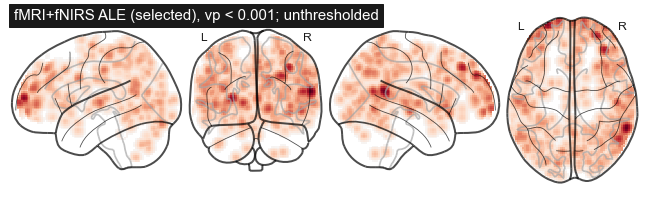

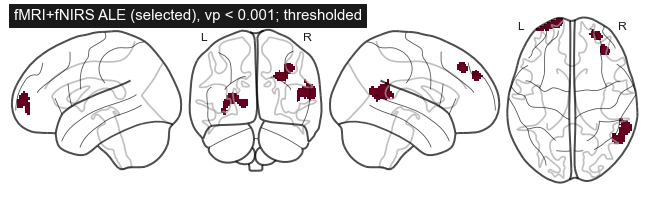

In [6]:
## FMRI+FNIRS ALE

# set fnirs sample sizes to n = 10 (corresponding to 10mm FWHM)
ds_fnirs_sel.metadata.sample_sizes = [[10]] * len(ds_fnirs_sel.metadata)
# merge datasets
ds_fmri_fnirs_sel = ds.merge(ds_fnirs_sel)

# run ale
_ = ale(data=ds_fmri_fnirs_sel, work_dir=join(wd, 'ale'), pref='aleFNIRSSEL_', vox_thr=0.001, cluster='mass',
        n_perm=n_perm, n_core=n_core, glassbrain_title='fMRI+fNIRS ALE (selected), vp < 0.001')

#### 3.3.2 Repeat fNIRS-fMRI-ALE with randomized fNIRS coordinates

To incorporate the spatial uncertainty of fNIRS data, we iteratively repeat (n = 1000) the fMRI+fNIRS ALE while randomizing fNIRS coordinates within a fixed-width sphere (radius 1cm) and a strongly constrained cortical template. As thresholding the ALE map every time using the non-parametric permutation-based method would exaggerate computation time, we use parametric thresholding to approximate the result (voxel-wise FDR correction, q < .01 & q < .001, cluster-extend > 200 qmm). To evaluate the result, we estimate the percentages of iterations in which we find significant clusters within the original clusters (without randomization of coordinates).

While the left SFG cluster is robust against spatial iteration of the coordinates, the right prefrontal clusters are more sensitive. However, using the q < .01 threshold, still in nearly 100 % of iterations both right prefrontal clusters remain existent.

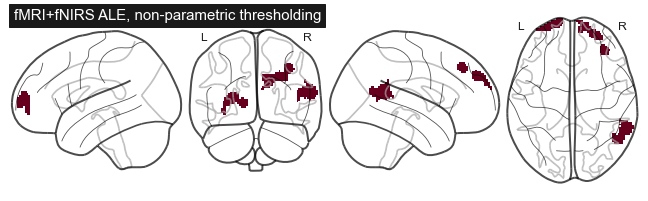

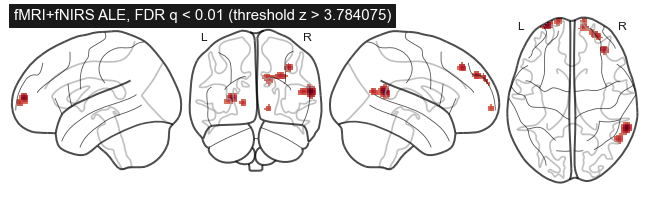

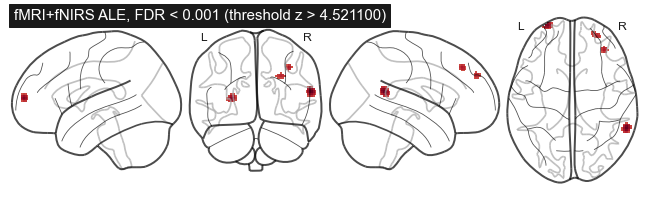

In [13]:
## PLOT "original" fMRI+fNIRS ALE maps using parametric and non parametric thresholding for comparison

# non-parametric thresholding
aleFNIRS_bin = load_img(join(wd, 'ale', 'aleFNIRS_thresh_bin.nii.gz'))
plot_gb(aleFNIRS_bin, title='fMRI+fNIRS ALE, non-parametric thresholding')

# parametric thresholding
aleFNIRS_z = load_img(join(wd, 'ale', 'aleFNIRS_z.nii.gz'))
aleFNIRS_z_thresh, vthresh = threshold_stats_img(aleFNIRS_z, alpha=0.01, height_control='fdr', two_sided=False, cluster_threshold=25)
plot_gb(aleFNIRS_z_thresh, title=f'fMRI+fNIRS ALE, FDR q < 0.01 (threshold z > {vthresh:2f})')
aleFNIRS_z_thresh, vthresh = threshold_stats_img(aleFNIRS_z, alpha=0.001, height_control='fdr', two_sided=False, cluster_threshold=25)
plot_gb(aleFNIRS_z_thresh, title=f'fMRI+fNIRS ALE, FDR < 0.001 (threshold z > {vthresh:2f})')

In [14]:
## PERFORM RANDOMIZATION

# number of iterations
n_rand = 1000
# make fMRI dataset for merging to avoid 'space' warning (has no effect on result)
ds_formerge = ds.copy()
ds_formerge.coordinates['space'] = 'MNI'
# mask to randomize coordinates in
mask_fnirs = load_img(join(wd, 'atlases', 'MNI152NLin6Asym_2mm_cortexmask_constrained.nii.gz'))
# get clusters of main fNIRS+fMRI ALE
ale_fnirs_idx = load_img(join(wd, 'ale', 'aleFNIRS_thresh_idx.nii.gz'))
ale_fnirs_idx_data = ale_fnirs_idx.get_fdata()
n_clusters = int(np.max(ale_fnirs_idx_data))
# prepare empty arrays
fnirs_rand_res01 = np.zeros([n_rand, n_clusters])
fnirs_rand_res001  = np.zeros([n_rand, n_clusters])

# permutate coordinates and save coverage of cluster in original fMRI+fNIRS ALE
for i in tqdm(range(n_rand)):
    # prepare ALE
    fit_ale = ALE()
    # randomize coordinates, radius is 5 as it has to be multiplied with 2mm voxel-size
    ds_fnirs_rand = ds_fnirs.copy()
    ds_fnirs_rand = rand_nimare_coords(ds_fnirs_rand, mask=mask_fnirs, radius=5, verbose=False)
    ds_fnirs_rand.coordinates['space'] = 'MNI'
    # merge datasets
    ds_fmri_fnirs_rand = ds_formerge.merge(ds_fnirs_rand)
    # perform ALE
    aleFNIRS_rand_res = fit_ale.fit(ds_fmri_fnirs_rand)
    aleFNIRS_rand_z = aleFNIRS_rand_res.get_map('z')
    # threshold, check if values in clusters & save
    # p < 0.01
    ale_fnirs_rand_z_thresh, _ = threshold_stats_img(aleFNIRS_rand_z, alpha=0.01, height_control='fdr', two_sided=False, cluster_threshold=25)
    cluster_check = np.unique((ale_fnirs_rand_z_thresh.get_fdata() > 0) * ale_fnirs_idx_data)
    fnirs_rand_res01[i,:] = [1 if c in cluster_check else 0 for c in range(n_clusters)]
    # p < 0.001
    ale_fnirs_rand_z_thresh, _ = threshold_stats_img(aleFNIRS_rand_z, alpha=0.001, height_control='fdr', two_sided=False, cluster_threshold=25) 
    cluster_check = np.unique((ale_fnirs_rand_z_thresh.get_fdata() > 0) * ale_fnirs_idx_data)
    fnirs_rand_res001[i,:] = [1 if c in cluster_check else 0 for c in range(n_clusters)] 
    # reset variables
    fit_ale = ds_fnirs_rand = ds_fmri_fnirs_rand = aleFNIRS_rand_res = aleFNIRS_rand_z = ale_fnirs_rand_z_thresh = cluster_check = None

# make dfs and show result
fnirs_rand_res01_df = pd.DataFrame(data=fnirs_rand_res01, index=None,
                                   columns=[f'cl{i}' for i in range(1, n_clusters+1)])
fnirs_rand_res01_df.to_csv(join(wd, 'fnirs', 'fnirs_ale01_randomization.csv'), index=False)
fnirs_rand_res001_df = pd.DataFrame(data=fnirs_rand_res001, index=None,
                                   columns=[f'cl{i}' for i in range(1, n_clusters+1)])
fnirs_rand_res001_df.to_csv(join(wd, 'fnirs', 'fnirs_ale001_randomization.csv'), index=False)
display(fnirs_rand_res01_df.mean(axis=0))
display(fnirs_rand_res001_df.mean(axis=0))

100%|██████████| 1000/1000 [3:12:49<00:00, 11.57s/it] 


cl1    1.000
cl2    1.000
cl3    0.989
cl4    0.976
dtype: float64

cl1    1.000
cl2    1.000
cl3    0.487
cl4    0.446
dtype: float64

## 4 Task-related and task-free connectivity

### 4.1 Meta-analytic connectivity modelling

#### 4.1.1 Run MACM

Using only the rTPJ cluster as seed (as the rSTG cluster proofed unstable), we calculate a network of task-related co-activation based on the BrainMap database ([Eickhoff et al., 2011](https://doi.org/10.1016/j.neuroimage.2011.05.021)).  
We search the BrainMap database ("normal mapping" + "activation only") for studies reporting at least one peak within the ALE cluster and perform a single ALE on these coordinates (settings as above, voxel-level threshold p < 0.001). 

We find a task-related network with mainly cortical clusters located in bilateral TPJ-related regions, left & right insulae and dlPFCs, SMA, right IPL, and subcortical regions.

In [ ]:
# Select studies with >= 1 coordinate in rTPJ ROI
ids_brainmap_ale_rTPJ = ds_brainmap.get_studies_by_mask(ale_rTPJ_bin)
ds_brainmap_ale_rTPJ = ds_brainmap.slice(ids_brainmap_ale_rTPJ)
print(f'{len(ids_brainmap_ale_rTPJ)}/{len(ds_brainmap.ids)} studies report at least one '
      'coordinate in ALE rTPJ cluster.')

# run MACM ALE
_ = ale(data=ds_brainmap_ale_rTPJ, work_dir=join(wd, 'macm'), pref='macm_rTPJ_', 
            vox_thr=v_thr, n_perm=n_perm, n_core=n_core, print_glassbrain=False, cluster='mass')

146/3098 studies report at least one coordinate in ALE rTPJ cluster.
The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



INFO:src.ale:Calculating ALE on 144 experiments with 146 contrasts, 2387 subjects and 7652 foci.
INFO:src.ale:Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, based on cluster mass with 5000 permutations.
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.
  0%|          | 0/5000 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
100%|██████████| 5000/5000 [2:00:31<00:00,  1.45s/it]  
INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.
INFO:src.ale:ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/project/data/macm



#### 4.1.2 Prepare volumes for following analyses and plot

cluster_id  peak_x  peak_y  peak_z  cluster_mean  volume_mm  \
0          1.0    60.0   -48.0    16.0      0.085033    28576.0   
1          2.0   -58.0   -42.0    22.0      0.066208    26280.0   
2          3.0   -32.0    20.0     2.0      0.068140    22456.0   
3          4.0    36.0    20.0    -2.0      0.069300    19760.0   
4          5.0    -4.0    12.0    48.0      0.070320    11416.0   
5          6.0   -10.0   -18.0     4.0      0.065970     5672.0   
6          7.0   -34.0   -50.0    46.0      0.061559     5448.0   
7          8.0    10.0   -16.0     6.0      0.060695     4664.0   
8          9.0    32.0   -58.0    48.0      0.060978     2872.0   
9         10.0    -2.0   -56.0    34.0      0.063224     1520.0   
10        11.0     2.0     0.0    40.0      0.053125       16.0   

                                                  aal  
0   39.39% Temporal_Mid_R; 18.20% Temporal_Sup_R; ...  
1   35.43% Temporal_Mid_L; 17.08% SupraMarginal_L;...  
2   24.90% Frontal_Inf_Tri_L; 21.66% Insula_L; 18....  
3   22.43% Frontal_Inf_Oper_R; 19.64% Insula_R; 19...  
4   32.94% Supp_Motor_Area_L; 24.04% Supp_Motor_Ar...  
5   54.72% Thalamus_L; 16.50% no_label; 14.10% Hip...  
6   64.32% Parietal_Inf_L; 27.02% Parietal_Sup_L; ...  
7   49.40% Thalamus_R; 24.19% no_label; 17.67% Pal...  
8   37.33% Parietal_Inf_R; 31.20% Angular_R; 30.08...  
9   50.53% Precuneus_L; 31.58% Cingulate_Post_L; 1...  
10                            100.00% Cingulate_Mid_R

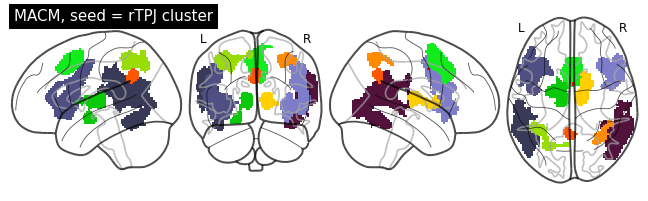

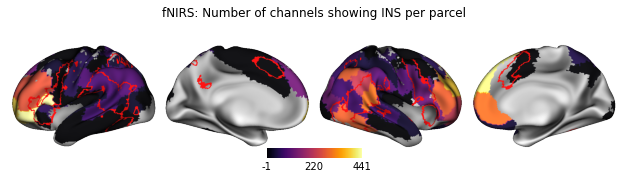

In [30]:
# MACM roi labels based on cluster list and image (below)
macm_rTPJ_labels = pd.DataFrame(['rTPJ', 'lTPJ', 'lPFCIns', 'rPFCIns', 'SMA', 
                                 'lTh', 'lIPL', 'rTh', 'rIPL', 'lPrec', 'rMCC'])
macm_rTPJ_labels.to_csv(join(wd, 'macm', 'macm_rTPJ_thresh_labels.csv'), 
                        index=False, header=None)

# load results for following analyses 
macm_rTPJ_idx = load_img(join(wd, 'macm', 'macm_rTPJ_thresh_idx.nii.gz'))
macm_rTPJ_bin = load_img(join(wd, 'macm', 'macm_rTPJ_thresh_bin.nii.gz'))
macm_rTPJ_z = load_img(join(wd, 'macm', 'macm_rTPJ_z.nii.gz'))

# save for RSFC analyses with CONN (see below) - we remove the smallest cluster (16 voxels)
macm_rTPJ_idx_RSFC = math_img('np.where(macm_idx==11, 0, macm_idx)', macm_idx=macm_rTPJ_idx)
macm_rTPJ_idx_RSFC.to_filename(join(wd, 'rsfc', 'macm_rTPJ_idx_forCONN.nii'))
macm_rTPJ_labels.loc[0:9,:].to_csv(join(wd, 'rsfc', 'macm_rTPJ_idx_forCONN.txt'), 
                                   index=False, header=None)

# plot MACM result - glassbrain
plot_gb(macm_rTPJ_idx, title='MACM, seed = rTPJ cluster', col='videen_style')
# - surface with fNIRS results
plot_surf(fnirs_vols['ratio_weighted'], title='fNIRS: Number of channels showing INS per parcel',
          overlay=macm_rTPJ_bin, interp='nearest', cmap='inferno')
# show cluster list
pd.read_csv(join(wd, 'macm', 'macm_rTPJ_thresh_stat_clusters.csv')).drop(['talairach_gyrus', 'talairach_ba'], axis=1)

#### 4.1.3 Spatial correlation between ALE and MACM maps

We evaluate whether the ALE and MACM results emerged from a spatial "activation" pattern that is present in both sets of coordinates (ALE: fMRI INS studies, MACM: studies spatially associated with the ALE cluster) but, due to a lack of power, did not result in further significant clusters in case of the primary ALE. For this, we correlate both unthresholded & z-transformed volumes spatially using spearman correlations. We first parcellate the volumes using the Schaefer/Tian 216 ROIs atlas. For visualization, we plot a scatter plot and mark all points (= atlas ROIs) that show an overlap with MACM clusters of at least 5% of each cluster's size.

We see (as expected) a general spatial correlation between ALE and MACM z-volumes, driven not only by higher ALE values in the rTPJ region (blue) but also by lTPJ (orange), lInsPFC (green) and rInsPFC (red) ROIs. 

Spearman`s r = 0.34


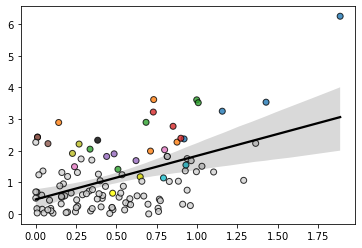

In [6]:
# load atlas and macm result
atlas_labels = pd.read_csv(join(wd, 'atlases', 'Schaefer100-7_TianS1_2mm.csv'), names=['idx', 'label', 'color'])

# MARKER COLORS FOR SCATTER PLOT 
cl_info = get_size_of_rois(macm_rTPJ_idx) # get macm cluster indices and sizes
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 
          'tab:pink', 'tab:olive', 'tab:cyan', 'yellow', 'black'] # cluster marker colors
atlas_labels['color'] = 'lightgrey' # non-cluster marker colors
# iterate over macm clusters
for i_cl in cl_info['idx']:
    cl_dat = macm_rTPJ_idx.get_fdata() # get cluster data
    cl_parcel = (cl_dat==i_cl) * atlas116.get_fdata() # intersect current cluster with atlas
    cl_size = cl_info['size'][cl_info['idx'] == i_cl].values[0] # size of current cluster 
    cl_parcel_sizes = get_size_of_rois(cl_parcel) # sizes of parcel-cluster intersections
    # keep parcel-cluster intersections that make at least 10% of cluster size
    cl_parcel_thr = cl_parcel_sizes[cl_parcel_sizes['size'] >= cl_size * 0.10] 
    # set color for all parcels overlapping with the current cluster
    atlas_labels['color'][atlas_labels['idx'].isin(cl_parcel_thr['idx'])] = colors[int(i_cl)-1] 

# CORRELATION AND SCATTER PLOT
# calculate spearman correlation between unthresholded MACM & ALE z maps and plot
_, cor_df = correlate_volumes_via_atlas(x_img=ale_z,
                                        y_img=macm_rTPJ_z,
                                        atlas=atlas116, method='spearman', colors=atlas_labels['color'])
cor_df.to_csv(join(wd, 'macm', 'cor_macm_ale.csv'), index=False) # save parcel-wise values
ale_z_parc = cor_df['dat1'].rename('ALE z') # get ale parcel values for following analyses

#### 4.1.4 Baseline adjusted meta-analytic connectivity modelling

When calculating MACM analyses using the ALE algorithm, the result is not adjusted for the base rate of voxel-wise activation. The SCALE (Specific Co-Activation Likelihood Estimation; [Langner et al., 2014](https://doi.org/10.1016/j.neuroimage.2014.06.007)) approach deals with this issue by generating a null-distribution reflecting the baseline probability of activation at any given voxel.  
We use it as addition to the MACM-ALE analysis as the current implementation of SCALE in NiMARE does not offer multiple comparison correction. Therefore, we will display the resulting map thresholded at uncorrected voxel-level p > 0.05 for visual comparison to the MACM-ALE-derived clusters. The baseline coordinates are drawn from the BrainMap database via Sleuth ("normal mapping", "Activations").

The left TPJ region seems to be the region most uniquely connected to the rTPJ.

In [ ]:
# get all BrainMap coordinates
scale_xyz = ds_brainmap.coordinates[["x", "y", "z"]].values

# run scale
scale = SCALE(xyz=scale_xyz, n_iters=n_perm)
scale_res = scale.fit(ds_brainmap_ale_rTPJ)
scale_res.save_maps(output_dir=join(wd, 'macm'), prefix='scale_rTPJ_')  

  0%|          | 0/5000 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:numexpr.utils:NumExpr defaulting to 4 threads.
100%|██████████| 5000/5000 [1:28:52<00:00,  1.07s/it]


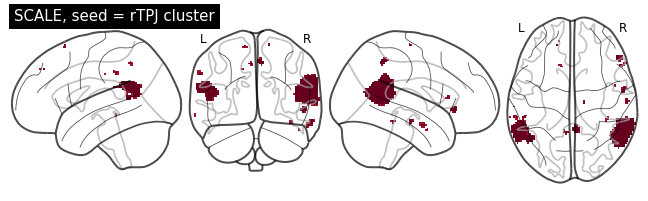

In [ ]:
# plot SCALE result, note: no multiple comparison correction implemented, 
# thresholded at uncorrected voxel-level p < 0.001
plot_gb(join(wd, 'macm', 'scale_rTPJ_logp.nii.gz'), title='SCALE, seed = rTPJ cluster', thresh=3)

### 4.2 Resting-state functional connectivity

We perform ROI-to-ROI resting-state functional connectivity (RSFC) analyses on [HCP data](https://www.humanconnectome.org/study/hcp-young-adult/document/900-subjects-data-release) using the [CONN toolbox](https://doi.org/10.1089/brain.2012.0073) in MATLAB. Here is the [CONN batch script](src/HCP_batch.m).
**Sample**: N = 120 unrelated subjects evenly drawn from each age group and gender. N = 115 after exclusion of subjects exceeding motion cut-offs.  
**Data**: S900 ICA-FIX denoised volumetric data; improved image reconstruction algorithm ("r277"); concatenated first two resting-state sessions (30 min); voxel-size 2x2x2 m^3.  
**Further processing**: Resample to 3mm isotropic resolution; Linear detrending & bandpass filtering (0.01 - 0.08 Hz); Semipartial correlations between averaged time series of each MACM cluster.  
**Statistics**: Two-sided one-sample t-test on r-to-z-transformed semipartial correlation coefficients representing each functional (directed) connection between the 10 MACM ROIs. Alpha-level: Bonferroni-corrected p < 0.05 to estimate the strongest connections within the co-activation network.

We see strong functional connections between the large MACM ROIs. Especially bilateral TPJs and IPLs seem to be connected with each other, in line with the SCALE result.

/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


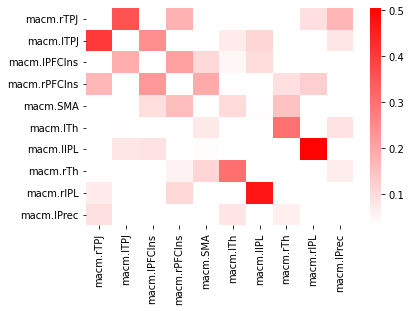

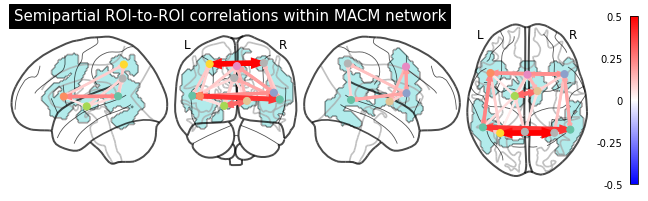

In [41]:
# load CONN result and motion data
conn_res = sp.io.loadmat(join(wd, 'rsfc', 'rsfc_macm_rTPJ_semipartial.mat'))
fwd = pd.read_csv(join(wd, 'rsfc', 'fwd.csv'))
# get connectivity data
z_all = conn_res.get('Z') # get data
z_all = z_all[:, :, (fwd['Exclude_motion']==1).to_list()] # get n=115 subjects below motion cut-offs
# get ROI coordinates
coord = np.concatenate(conn_res.get('xyz'))
coord = [c[0] for c in coord]
coord = np.array(coord)
# get ROI labels
labels = np.concatenate(conn_res.get('names'))
labels = [l[0] for l in labels]

# calculate positive-sided one-sample t-test against zero per connection
z_p, z_t = np.ones(z_all.shape[:2]), np.ones(z_all.shape[:2])
for r in range(z_p.shape[0]):
    for c in range(z_p.shape[1]):
        t, p = sp.stats.ttest_1samp(z_all[r, c, :], 0, alternative='two-sided')
        z_p[r, c], z_t[r, c] = p, t
        
# get mean z-value per connection across subjects
z = np.mean(z_all, 2)
# remove z-connections below Bonferroni-corrected p < 0.05
z_thresh = np.where((z_p < 0.05/90) & (z_t > 0), z, 'nan').astype(float)
# save matrix 
pd.DataFrame(z_thresh).to_csv(join(wd, 'rsfc', 'rsfc_cormat.csv'), index=None, header=labels)
pd.DataFrame(z).to_csv(join(wd, 'rsfc', 'rsfc_cormat_nothresh.csv'), index=None, header=labels)

# plot FC matrix and connectome on glass brain 
# warnings point at plotting functions, no influence on data
heatmap(pd.DataFrame(z_thresh, columns=labels, index=labels), cmap='red_transparent_full_alpha_range')
p = plot_connectome(z_thresh, coord, display_mode='lyrz', colorbar=True, 
                title='Semipartial ROI-to-ROI correlations within MACM network')
p.add_contours(macm_rTPJ_bin, filled=True, alpha=0.3, colors=['c'])
p.add_contours(macm_rTPJ_bin, colors=['k'], linewidths=0.1)

## 5 Meta-analytic contextualization

### 5.1 Neurosynth topics

We assess associations between ALE results and functional domains reported in the literature based on the Neurosynth database. Version 7 of the Neurosynth database consists of over 14000 imaging studies with respective coordinates. From text information of all studies, 200 "topics" of clustering word-families are generated using Latent Dirichlet Allocation (LDA; see [Poldrack et al., 2012](https://doi.org/10.1371/journal.pcbi.1002707)). From these 200 topics we excluded 109 topics representing too general, solely anatomical, or disease-related features. Each study in the database has one values associating it with each of the selected topics. We use two approaches:  
ROI-decoding: Based on the rTPJ roi, we use the topics in the same way as BrainMap behavioral domains are used when estimating reverse and forward inference via the BrainMap database.
Whole-brain-decoding: Based on the unthresholded ALE z-map, we look for spatial associations to topic-maps generated from the Neurosynth database 

#### 5.1.1 ROI-based neurosynth topic associations

We calculate reverse and forward inference estimates for the rTPJ ROI and the MACM network following the BrainMap approach (e.g., [Laird et al., 2009](https://doi.org/10.3389/neuro.11.023.2009)).  
In the forward inference approach, the functional profile of a ROI is determined by identifying LDA topics for which the probability of finding activation in the respective ROI is significantly higher than the overall (a priori) chance across the entire database: P(Activation|Topic) > P(Activation). Binominal tests with FDR correction are used to assess significance.  
In the reverse inference approach, the functional profile is determined by identifying the most likely LDA topic, given activation in a particular ROI: P(Topic|Activation). This probability is derived from P(Activation|Topic) using Bayes' rule, significance is assessed using chi-squared tests (FDR-corrected).

In [ ]:
# load selected LDA topics
topics_selected = pd.read_csv(join(wd, 'datasets', 'neurosynth', 'neurosynth_LDA200_selected.txt'),
                              header=None)
topics_selected = ['LDA200_abstract_weight__'+t for t in topics_selected[0]]

# Prepare decoder
decoder = BrainMapDecoder(correction='fdr_bh', 
                          frequency_threshold=0.001,
                          u=0.05, 
                          features=topics_selected)

# Select studies with >= 1 coordinate in rTPJ ROI
ids_neurosynth_ale_rTPJ = ds_neurosynth.get_studies_by_mask(ale_rTPJ_bin)
print(f'{len(ids_neurosynth_ale_rTPJ)}/{len(ds_neurosynth.ids)} studies report at least one '
      'coordinate in ALE rTPJ cluster.')

# Run decoding
decoder.fit(ds_neurosynth)
topics_roi_rTPJ_res = decoder.transform(ids=ids_neurosynth_ale_rTPJ)

# Save & print
topics_roi_rTPJ_res.to_csv(join(wd, 'context', 'topics_roi_ale_rTPJ.csv'))
topics_roi_rTPJ_res[topics_roi_rTPJ_res['pReverse' and 'pForward'] < 0.05].sort_values(by='pReverse')

772/14371 studies report at least one coordinate in ALE rTPJ cluster.


pForward  zForward  \
Term                                                                         
LDA200_abstract_weight__145_mind_mental_social      6.749179e-08  5.397723   
LDA200_abstract_weight__143_action_actions_obse...  2.060854e-04  3.711438   
LDA200_abstract_weight__82_motion_mt_moving         1.826280e-05  4.285135   
LDA200_abstract_weight__115_face_faces_fusiform     4.757364e-02  1.981157   
LDA200_abstract_weight__154_social_interactions...  1.196150e-02  2.513278   
LDA200_abstract_weight__138_real_virtual_reality    2.738830e-02 -2.205939   
LDA200_abstract_weight__99_detection_novelty_od...  2.530164e-02 -2.236766   

                                                    likelihoodForward  \
Term                                                                    
LDA200_abstract_weight__145_mind_mental_social               1.905402   
LDA200_abstract_weight__143_action_actions_obse...           1.558843   
LDA200_abstract_weight__82_motion_mt_moving                  1.836549   
LDA200_abstract_weight__115_face_faces_fusiform              1.342473   
LDA200_abstract_weight__154_social_interactions...           1.429263   
LDA200_abstract_weight__138_real_virtual_reality             1.543060   
LDA200_abstract_weight__99_detection_novelty_od...           1.706328   

                                                        pReverse  zReverse  \
Term                                                                         
LDA200_abstract_weight__145_mind_mental_social      9.580990e-12  6.812661   
LDA200_abstract_weight__143_action_actions_obse...  1.060306e-07  5.316073   
LDA200_abstract_weight__82_motion_mt_moving         1.558766e-07  5.245479   
LDA200_abstract_weight__115_face_faces_fusiform     1.084701e-02  2.547589   
LDA200_abstract_weight__154_social_interactions...  1.235608e-02  2.501808   
LDA200_abstract_weight__138_real_virtual_reality    2.095536e-02  2.308788   
LDA200_abstract_weight__99_detection_novelty_od...  7.190542e-02  1.799716   

                                                    probReverse  
Term                                                             
LDA200_abstract_weight__145_mind_mental_social         0.019152  
LDA200_abstract_weight__143_action_actions_obse...     0.018295  
LDA200_abstract_weight__82_motion_mt_moving            0.014204  
LDA200_abstract_weight__115_face_faces_fusiform        0.015285  
LDA200_abstract_weight__154_social_interactions...     0.017319  
LDA200_abstract_weight__138_real_virtual_reality       0.008993  
LDA200_abstract_weight__99_detection_novelty_od...     0.006984

#### 5.1.2 Whole-brain-based neurosynth topic associations

We calculate spatial correlations between the unthresholded ALE-z/ MACM-z maps and generated LDA topic maps. Instead of correlating voxel-wise values, we calculate spearman correlations for parcellated data according to a functionally defined whole-brain atlas (216 ROIs; [Schaefer et al., 2018](https://doi.org/10.1093/cercor/bhx179); [Tian et al., 2020](https://doi.org/10.1038/s41593-020-00711-6)) as the overall number of voxels probably exceeds the degrees of freedom present in the data. The correlation coefficients have to be interpreted with caution as we cannot rely on p-values here.

In [ ]:
## Create LDA-topic maps
# Use this code to create LDA topic maps, will skip existing files - ALREADY CREATED
#create_neurosynth_topic_maps(ds_neurosynth, estimator='mkdachi2', topics=topics_selected, 
#                             save_path=join(wd, 'context', 'topic_maps'), topic_thresh=0.001, 
#                             sample_size=10, maps=['z_desc-specificity'], overwrite=False)

## Load topic maps
topic_maps = glob(join(wd, 'context', 'topic_maps', 'neurosynth_topic_*_z_desc-specificity.nii.gz')) # topic maps

rs = list()
for topic_map in topic_maps:
    r, _ = correlate_volumes_via_atlas(x_img=topic_map, y_img=ale_z, atlas=atlas116, method='spearman', pl=False, pr=False)
    rs.append(r)
topics_wholebrain_res = pd.DataFrame({'topic_map': topic_maps,
                                      'topic': [split(m)[1].split('.nii.gz')[0] for m in topic_maps],
                                      'r': rs})

# print & save
topics_wholebrain_res.to_csv(join(wd, 'context', 'topics_wholebrain.csv'))
display(topics_wholebrain_res[['topic', 'r']].sort_values(by='r', ascending=False).head(10))

topic         r
72  neurosynth_topic_64_attention_attentional_visu...  0.673453
47  neurosynth_topic_97_adaptation_selective_stimu...  0.562039
54  neurosynth_topic_143_action_actions_observatio...  0.561939
26  neurosynth_topic_108_visual_auditory_sensory_1...  0.541249
69  neurosynth_topic_150_reading_phonological_read...  0.513816
0   neurosynth_topic_152_perceptual_perception_vis...  0.508911
33  neurosynth_topic_18_color_shape_shapes_478_z_d...  0.503629
61  neurosynth_topic_82_motion_mt_moving_771_z_des...  0.496663
46  neurosynth_topic_19_illusion_physical_perceive...  0.488636
5   neurosynth_topic_193_mirror_video_imitation_76...  0.471491

### 5.2 Social interaction & theory of mind

To assess whether the TPJ cluster and the MACM network show spatial overlap with networks associated with (1) general social interaction ([Feng et al., 2021](https://doi.org/10.1016/j.neubiorev.2021.03.025)), (2) different components of theory of mind ([Schurz et al., 2021](https://doi.org/10.1037/bul0000303)), we calculate spatial conjunction maps and assess overlap via relative and absolute distributions within/across these networks (e.g. [Chen et al., 2018](https://doi.org/10.1007/s00429-018-1727-9)).
The relative distribution is calculated as the proportion of "INS-voxels" within a given ROI vs. all "INS-voxels". The absolute distribution resembles the proportion of "INS-voxels" within a given ROI vs. all voxels within this ROI.

#### 5.2.1 Social interaction: Feng et al., 2021

roiName  nvox_roi  targetNr            targetName  nvox_target  \
0   ale_rTPJ_cluster       357         1  Feng_socialNonsocial         2768   
0  macm_rTPJ_network     16085         1  Feng_socialNonsocial         2768   

   nvox_overlap  relDistr  absDistr  
0           113  0.316527  0.040824  
0          1387  0.086229  0.501084

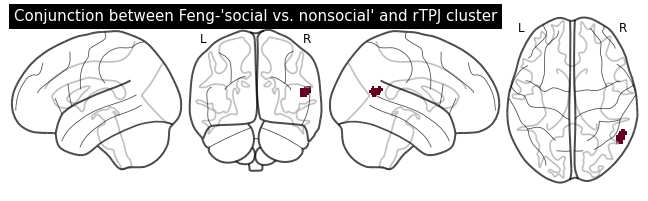

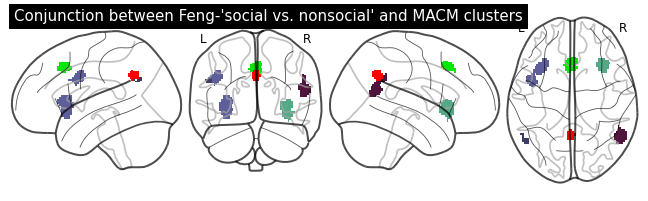

In [ ]:
# calculate conjunction maps
ma_feng = join(wd, 'atlases', 'Feng_socialNonsocial.nii.gz')
ma_feng_rTPJ = math_img('feng * rTPJ', feng=ma_feng, rTPJ=ale_rTPJ_bin)
ma_feng_macm = math_img('feng * macm', feng=ma_feng, macm=macm_rTPJ_idx)

# save & plot
ma_feng_rTPJ.to_filename(join(wd, 'context', 'feng_ale_conjunction.nii.gz'))
ma_feng_macm.to_filename(join(wd, 'context', 'feng_macm_conjunction.nii.gz'))
plot_gb(ma_feng_rTPJ, title="Conjunction between Feng-'social vs. nonsocial' and rTPJ cluster")
plot_gb(ma_feng_macm, title="Conjunction between Feng-'social vs. nonsocial' and MACM clusters",
        col='videen_style')

# calculate distributions
distr_Feng = rel_abs_distributions(
    roi_vols    =[ale_rTPJ_bin, macm_rTPJ_bin],
    target_vol  =ma_feng, 
    roi_labs    =['ale_rTPJ_cluster', 'macm_rTPJ_network'],
    target_labs =['Feng_socialNonsocial'])
# save and show
distr_Feng.to_csv(join(wd, 'context', 'feng_distributions.csv'), index=False)
distr_Feng.sort_values(by='relDistr', ascending=False)

#### 5.2.2 Theory of mind: Schurz et al., 2021

roiName  nvox_roi  targetNr            targetName  nvox_target  \
0   ale_rTPJ_cluster       357         1  Schurz_ToM_cognitive        27266   
0  macm_rTPJ_network     16085         1  Schurz_ToM_cognitive        27266   

   nvox_overlap  relDistr  absDistr  
0           341  0.955182  0.012506  
0          3756  0.233509  0.137754

roiName  nvox_roi  targetNr               targetName  \
0   ale_rTPJ_cluster       357         1  Schurz_ToM_intermediate   
0  macm_rTPJ_network     16085         1  Schurz_ToM_intermediate   

   nvox_target  nvox_overlap  relDistr  absDistr  
0        25597           339  0.949580  0.013244  
0        25597          7298  0.453715  0.285112

roiName  nvox_roi  targetNr            targetName  nvox_target  \
0   ale_rTPJ_cluster       357         1  Schurz_ToM_affective        30759   
0  macm_rTPJ_network     16085         1  Schurz_ToM_affective        30759   

   nvox_overlap  relDistr  absDistr  
0           135  0.378151  0.004389  
0          8521  0.529748  0.277025

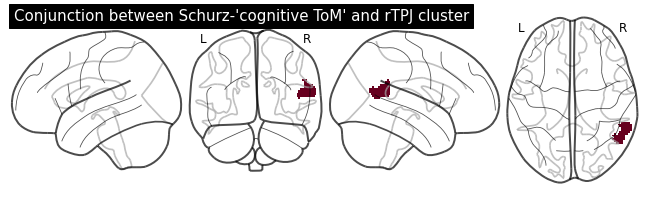

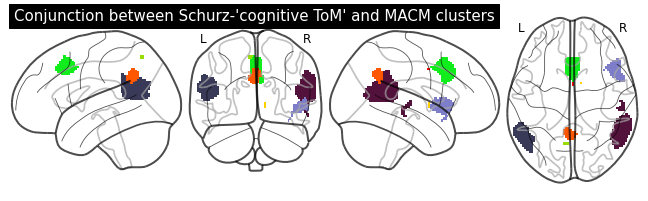

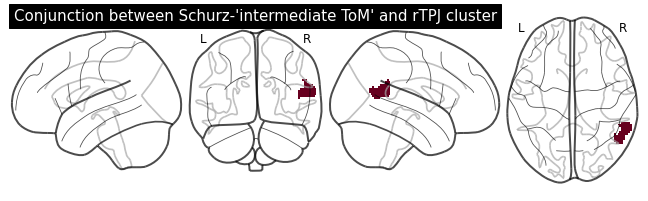

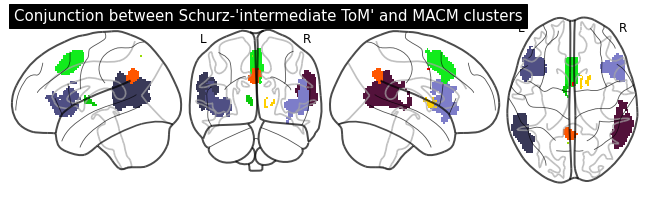

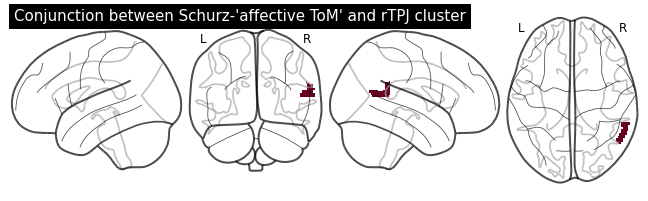

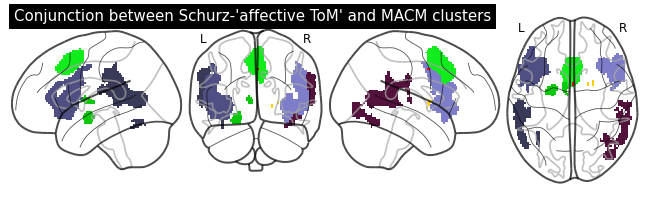

In [ ]:
## calculate conjunction maps
# cognitive ToM
ma_schurz_cognitive = join(wd, 'atlases', 'Schurz_ToM_cognitive.nii.gz')
ma_schurz_cognitive_rTPJ = math_img('schurz * rTPJ', schurz=ma_schurz_cognitive, rTPJ=ale_rTPJ_bin)
ma_schurz_cognitive_macm = math_img('schurz * macm', schurz=ma_schurz_cognitive, macm=macm_rTPJ_idx)
# intermediate ToM
ma_schurz_intermediate = join(wd, 'atlases', 'Schurz_ToM_intermediate.nii.gz')
ma_schurz_intermediate_rTPJ = math_img('schurz * rTPJ', schurz=ma_schurz_intermediate, rTPJ=ale_rTPJ_bin)
ma_schurz_intermediate_macm = math_img('schurz * macm', schurz=ma_schurz_intermediate, macm=macm_rTPJ_idx)
# affective ToM
ma_schurz_affective = join(wd, 'atlases', 'Schurz_ToM_affective.nii.gz')
ma_schurz_affective_rTPJ = math_img('schurz * rTPJ', schurz=ma_schurz_affective, rTPJ=ale_rTPJ_bin)
ma_schurz_affective_macm = math_img('schurz * macm', schurz=ma_schurz_affective, macm=macm_rTPJ_idx)

## save & plot
# cognitive
ma_schurz_cognitive_rTPJ.to_filename(join(wd, 'context', 'schurz_cognitive_ale_conjunction.nii.gz'))
ma_schurz_cognitive_macm.to_filename(join(wd, 'context', 'schurz_cognitive_macm_conjunction.nii.gz'))
plot_gb(ma_schurz_cognitive_rTPJ, title="Conjunction between Schurz-'cognitive ToM' and rTPJ cluster")
plot_gb(ma_schurz_cognitive_macm, title="Conjunction between Schurz-'cognitive ToM' and MACM clusters",
        col='videen_style')
# intermediate
ma_schurz_intermediate_rTPJ.to_filename(join(wd, 'context', 'schurz_intermediate_ale_conjunction.nii.gz'))
ma_schurz_intermediate_macm.to_filename(join(wd, 'context', 'schurz_intermediate_macm_conjunction.nii.gz'))
plot_gb(ma_schurz_intermediate_rTPJ, title="Conjunction between Schurz-'intermediate ToM' and rTPJ cluster")
plot_gb(ma_schurz_intermediate_macm, title="Conjunction between Schurz-'intermediate ToM' and MACM clusters",
        col='videen_style')
# affective
ma_schurz_affective_rTPJ.to_filename(join(wd, 'context', 'schurz_affective_ale_conjunction.nii.gz'))
ma_schurz_affective_macm.to_filename(join(wd, 'context', 'schurz_affective_macm_conjunction.nii.gz'))
plot_gb(ma_schurz_affective_rTPJ, title="Conjunction between Schurz-'affective ToM' and rTPJ cluster")
plot_gb(ma_schurz_affective_macm, title="Conjunction between Schurz-'affective ToM' and MACM clusters",
        col='videen_style')

## calculate distributions, save and show
distr_Schurz_cognitive = rel_abs_distributions(roi_vols=[ale_rTPJ_bin, macm_rTPJ_bin], target_vol=ma_schurz_cognitive, 
                                     roi_labs=['ale_rTPJ_cluster', 'macm_rTPJ_network'], target_labs=['Schurz_ToM_cognitive'])
distr_Schurz_cognitive.to_csv(join(wd, 'context', 'schurz_cognitive_distributions.csv'), index=False)
display(distr_Schurz_cognitive)
distr_Schurz_intermediate = rel_abs_distributions(roi_vols=[ale_rTPJ_bin, macm_rTPJ_bin], target_vol=ma_schurz_intermediate, 
                                     roi_labs=['ale_rTPJ_cluster', 'macm_rTPJ_network'], target_labs=['Schurz_ToM_intermediate'])
distr_Schurz_intermediate.to_csv(join(wd, 'context', 'schurz_intermediate_distributions.csv'), index=False)
display(distr_Schurz_intermediate)
distr_Schurz_affective = rel_abs_distributions(roi_vols=[ale_rTPJ_bin, macm_rTPJ_bin], target_vol=ma_schurz_affective, 
                                     roi_labs=['ale_rTPJ_cluster', 'macm_rTPJ_network'], target_labs=['Schurz_ToM_affective'])
distr_Schurz_affective.to_csv(join(wd, 'context', 'schurz_affective_distributions.csv'), index=False)
display(distr_Schurz_affective)

### 5.3 Resting-state networks

We quantify the spatial overlap of our results (rTPJ cluster, MACM network) with seven established RSNs (cortical, striatum and thalamus) ([Yeo & Krienen et al., 2011](https://doi.org/10.1152/jn.00338.2011)) as the relative and absolute distributions of ROIs across the given networks (see above).  

Both, rTPJ cluster and MACM network are spatially associated with the default mode network (DMN) and ventral and dorsal attention networks (VAN/DAN). The MACM network is additionally overlapping with the frontoparietal network (FPN).

In [ ]:
# Calculate network distributions with 7 Yeo & Krienen et al., 2011 RSNs
# Input: binarized ALE cluster, binarized MACM network
distr_RSN = rel_abs_distributions(
    roi_vols    =[ale_rTPJ_bin, macm_rTPJ_bin],
    target_vol  =load_img(join(wd, 'atlases', 'Yeo7_combined_2mm.nii.gz')), 
    roi_labs    =['ale_rTPJ_cluster', 'macm_rTPJ_network'],
    target_labs =pd.read_csv(join(wd, 'atlases', 'Yeo7_combined_2mm.csv'), header=None)[1])
# save and show
distr_RSN.to_csv(join(wd, 'context', 'rsn_distributions.csv'), index=False)
display(distr_RSN[distr_RSN['roiName']=='ale_rTPJ_cluster'].sort_values(by='relDistr', ascending=False))
display(distr_RSN[distr_RSN['roiName']=='macm_rTPJ_network'].sort_values(by='relDistr', ascending=False))

roiName  nvox_roi  targetNr targetName  nvox_target  nvox_overlap  \
6  ale_rTPJ_cluster       357         7        DMN        31304           162   
2  ale_rTPJ_cluster       357         3        DAN        15378           124   
3  ale_rTPJ_cluster       357         4        VAN        15153            62   
0  ale_rTPJ_cluster       357         1         VN        22753             6   
5  ale_rTPJ_cluster       357         6        FPN        20924             2   
1  ale_rTPJ_cluster       357         2        SMN        20128             0   
4  ale_rTPJ_cluster       357         5         LN        11958             0   

   relDistr  absDistr  
6  0.453782  0.005175  
2  0.347339  0.008063  
3  0.173669  0.004092  
0  0.016807  0.000264  
5  0.005602  0.000096  
1  0.000000  0.000000  
4  0.000000  0.000000

roiName  nvox_roi  targetNr targetName  nvox_target  \
3  macm_rTPJ_network     16085         4        VAN        15153   
2  macm_rTPJ_network     16085         3        DAN        15378   
6  macm_rTPJ_network     16085         7        DMN        31304   
5  macm_rTPJ_network     16085         6        FPN        20924   
0  macm_rTPJ_network     16085         1         VN        22753   
1  macm_rTPJ_network     16085         2        SMN        20128   
4  macm_rTPJ_network     16085         5         LN        11958   

   nvox_overlap  relDistr  absDistr  
3          4376  0.272055  0.288788  
2          2857  0.177619  0.185785  
6          2835  0.176251  0.090564  
5          2340  0.145477  0.111833  
0          1444  0.089773  0.063464  
1           782  0.048617  0.038851  
4             1  0.000062  0.000084

### 5.4 TPJ subunits

[Bzdok et al. (2013)](https://doi.org/10.1016/j.neuroimage.2013.05.046) characterized two subunits of the right TPJ with distinct connectivity and behavioral profiles. To quantify the affiliation of our rTPJ cluster with these subunits, we calculate relative and absolute distributions within the Bzdok-ROIs.

We see that our rTPJ cluster shows overlap with both rTPJ subunits, however, with a tendency towards the posterior rTPJ. 

In [ ]:
# Calculate distributions within Bzdok et al., 2011 rTPJ parcellation 
distr_TPJ = rel_abs_distributions(
    roi_vols    =[ale_rTPJ_bin],
    target_vol  =load_img(join(wd, 'atlases', 'BzdokTPJ_combined_2mm.nii.gz')), 
    roi_labs    =['ale_rTPJ_cluster'],
    target_labs =pd.read_csv(join(wd, 'atlases', 'BzdokTPJ_combined_2mm.csv'), header=None)[1])

# save results & print tables
distr_TPJ.to_csv(join(wd, 'context', 'bzdok_distributions.csv'), index=False)
display(distr_TPJ)

roiName  nvox_roi  targetNr targetName  nvox_target  nvox_overlap  \
0  ale_rTPJ_cluster       357         1       aTPJ          434            89   
1  ale_rTPJ_cluster       357         2       pTPJ          310           114   

   relDistr  absDistr  
0  0.249300  0.205069  
1  0.319328  0.367742

## 6 Molecular and genetic contextualization

To test prior and generate new hypothesizes on the biological mechanisms underlying INS, we assess associations to molecular functions, cell populations, and developmental enrichment patterns. Prior hypotheses (e.g., [Gvirts & Perlmutter, 2020](https://doi.org/10.1177/1073858419861912)) specifically suggest involvement of dopamine and oxytocin in INS.  

We use the Matlab-based JuSpace toolbox ([Dukart et al., 2021](https://doi.org/10.1002/hbm.25244)) to calculate spatial (Spearman) correlations between multimodal maps and the unthresholded ALE map after parcellation with the 116 parcel atlas. Significance is assessed by comparison to 5000 spatial null maps generated from the multimodal maps by JuSpace.  
Furthermore, we investigate whether INS is spatially associated to certain gene functions, distributions of neuronal cell types defined by marker genes as published in [Wang et al. (2018)](https://doi.org/10.1126/science.aat8464) (TPM cell-profiles derived from clustering analyses - 389 genes, 24 cell types), and whether INS-related genes are regionally enriched at specific developmental stages ([Miller et al., 2014](https://doi.org/10.1038/nature13185)). For that, we use Gene-category enrichment analysis (GCEA) with ensemble-based null models to correctly account for false-positives due to gene-coexpression and within-phenotype spatial autocorrelation ([Fulcher at al., 2021](https://doi.org/10.1038/s41467-021-22862-1)). To perform GCEA, we modified the Matlab toolbox published by Fulcher et al. to incorporate cell-type categories and made it available as a standalone toolbox, [ABAnnotate](https://doi.org/10.5281/zenodo.6463328), which is available from: [https://github.com/LeonDLotter/ABAnnotate](https://github.com/LeonDLotter/ABAnnotate).

In [31]:
# first, get data

# get roi-wise mRNA expression data (if not already done so, will 
# download complete AHBA data @ ~4GB) through the abagen toolbox
mRNA_parcellated = get_expression_data(atlas=atlas116)
print(f'{mRNA_parcellated.shape[1]} genes in processed AHBA dataset.')

# target genes
genes_trg = ['OXT', 'OXTR', 'CD38'] # genes to investigate 
mRNA_parcellated_trg = mRNA_parcellated[genes_trg].reset_index(drop=True)
print(f'{mRNA_parcellated_trg.shape[1]} mRNA maps selected.')

# get parcellated PET data
pet_parcellated = pd.read_csv(join(wd, 'datasets', 'pet_parcellated_data.csv'))
print(f'{pet_parcellated.shape[1]} PET maps available.')

# combine target mRNA and PET dataframes
PETmRNA_parcellated = pd.concat([pet_parcellated, mRNA_parcellated_trg], axis=1)

# get parcellated ALE data
ale_z_parc = pd.read_csv(join(wd, 'macm', 'cor_macm_ale.csv'))['dat1'].rename('ALE z') # get ale parcel values for following analyses

/Applications/Anaconda/anaconda3/envs/masync/lib/python3.8/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/Applications/Anaconda/anaconda3/envs/masync/lib/python3.8/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/Applications/Anaconda/anaconda3/envs/masync/lib/python3.8/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gene_by_label = (microarray.groupby('label')
/Applications/Anaconda/anaconda3/envs/masync/lib/python3.8/site-packages/abagen/samples_.py:404: FutureWarning: The frame.append method is deprecated and will be removed

15633 genes in processed AHBA dataset.
3 mRNA maps selected.
20 PET maps available.


### 6.1 Associations to neurotransmitter receptors & gene expression

A large range of transmitter maps is drawn from JuSpace and neuromaps ([Markello et al., 2022](https://doi.org/10.1101/2022.01.06.475081)). PET maps were parcellated, the parcel-wise data z-scored, and weighted averages were calculated for maps using the same tracer (see [parcellate_pet.py](src/parcellate_pet.py)). As no PET-maps for oxytocin exist, we use mRNA expression data from the Allen human brain atlas ([Hawrylycz et al., 2012](https://doi.org/10.1038/nature11405)). The data are extracted parcel-wise from post-mortem brains using the standard settings provided in the abagen toolbox ([Markello et al., 2021](https://doi.org/10.7554/eLife.72129)). JuSpace is used for correlation analyses. Resulting exact p-values are FDR-corrected.

We cannot confirm a correlation to dopamine or oxytocin. However, we find significant spatial associations between INS and distributions of GABAa > 5HT2a > mGluR5 & NET receptors.

In [25]:
# Run Matlab-Juspace script from python using matlab/python engine. 
# Requires Matlab, Juspace, SPM12, and the project folder to be on the matlab path

# initialize matlab engine
eng = matlab.engine.start_matlab()

# make JuSpace input volumes. We parcellated the data beforehand but have
# to put them into parcellated 3D volumes for Juspace. As null maps are 
# calculated from atlas data, this does not bias the results
parcel_files = list()
for map in PETmRNA_parcellated:
    _, parcel_file = parcel_data_to_volume(PETmRNA_parcellated[map], atlas116, 
                                           save_path=join(wd, 'context', 'parcel_maps', f'{map}.nii.gz'))
    parcel_files.append(parcel_file)

# run Juspace wrapper function through matlab engine
PETmRNA_JuSpace_res_file = eng.juspace_correlations(
    [ale_z.get_filename()], # ale z volume
    parcel_files,  # parcellated PET/mRNA volumes
    [atlas116.get_filename()], # atlas volume
    n_perm, # number of generated null maps
    join(wd, 'context', 'PETmRNA_ale_z_JuSpace.csv')) # output file
eng.quit()

# get JuSpace result
PETmRNA_JuSpace_res = pd.read_csv(PETmRNA_JuSpace_res_file) 

# apply FDR correction & create new table
sig, q = fdrcorrection(PETmRNA_JuSpace_res.p_exact)
PETmRNA_res = pd.DataFrame({
    'PETmRNA': PETmRNA_JuSpace_res['PET Map'], # pet map 
    'zr': PETmRNA_JuSpace_res["Mean Fisher's z (Spearman rho)"], # r-to-z transformed correlation coefficient
    'p': PETmRNA_JuSpace_res.p_exact, # non-parametric p value
    'q': q, # FDR corrected p value
    'sig': sig # FDR significant True/False
})

# save & show 
PETmRNA_res.to_csv(join(wd, 'context', 'PETmRNA_ale_z_fdr.csv'))
display(PETmRNA_res.sort_values(by='zr', ascending=False))

Unzipping input volume(s) (if necessary).
Unzipping: /Users/leonlotter/MAsync/project/data/ale/ale_z.nii.gz
Unzipping target volume(s) (if necessary).
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/5HT1a.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/5HT1b.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/5HT2a.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/5HT4.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/5HT6.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/5HTT.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/a4b2.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/CB1.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/D1.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/D2.nii.gz
Unzipping: /Users/leonlotter/MAsync/proje

PETmRNA        zr         p         q    sig
12   GABAa  0.438088  0.002599  0.008541   True
2    5HT2a  0.344208  0.000400  0.002300   True
15  mGluR5  0.249337  0.006399  0.016097   True
17     NET  0.243238  0.008598  0.017247   True
1    5HT1b  0.235028  0.061588  0.088533  False
14      M1  0.183075  0.051390  0.078798  False
4     5HT6  0.113639  0.219760  0.240690  False
0    5HT1a  0.058067  0.640670  0.640670  False
6     a4b2 -0.137054  0.146170  0.168096  False
7      CB1 -0.146907  0.326930  0.341790  False
18    NMDA -0.195473  0.108180  0.138230  False
8       D1 -0.230469  0.013797  0.024410   True
20     OXT -0.239263  0.008998  0.017247   True
9       D2 -0.258359  0.006999  0.016097   True
13      H3 -0.262059  0.075785  0.102533  False
3     5HT4 -0.265089  0.004599  0.013222   True
16      MU -0.326973  0.126370  0.152974  False
10     DAT -0.328075  0.001000  0.004599   True
11   FDOPA -0.328699  0.016197  0.026609   True
19   VAChT -0.375658  0.000200  0.001533   True
5     5HTT -0.448281  0.000200  0.001533   True
21    OXTR -0.465869  0.001400  0.005366   True
22    CD38 -0.622699  0.000200  0.001533   True

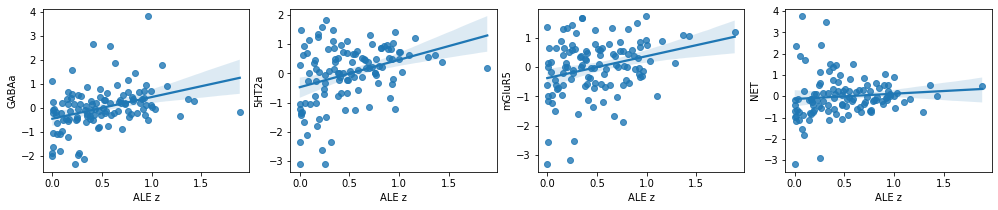

In [32]:
# plot GABA, 5HT2a, mGluR5, and NET vs INS
fig, axes = plt.subplots(1,4, figsize=(17,3))
for i, map in enumerate(['GABAa', '5HT2a', 'mGluR5', 'NET']):
    regplot(x=ale_z_parc, y=PETmRNA_parcellated[map], ax=axes[i])

### 6.2 Gene-category enrichment analyses

#### 6.2.1 GCEA on neuronal cell types

The ABAnnotate toolbox performs the following steps: The ALE-z volume is parcellated according to the SchaeferTian116 atlas and null models corrected for spatial-autocorrelation are generated (function taken from JuSpace). For each null phenotype and each null category a correlation score is obtained by correlating the null phenotype with each gene and averaging the z-transformed correlation coefficient (Spearman) within each category. The obtained correlation coefficients are then compared to the "real" category-wise correlation coefficients obtained by correlating the "real" phenotype with all genes in each category and averaging the correlation coefficients per category. The resulting p-values are FDR-corrected (BH).  

Here, we use markers of different neuronal cell types to establish associations to INS and validate the PET neurotransmitter associations.

We find an association between INS, a subclass of excitatory neurons, and two subclasses of inhibitory neurons.

In [9]:
eng = matlab.engine.start_matlab() 

# run ABAnnotate
_ = eng.ABAnnotate({
    'analysis_name': 'ale_z_PsychEncodeTPM', # analysis name
    'phenotype': ale_z.get_filename(), # phenotype volume (ALE z)
    'n_nulls': n_perm, # number of phenotype & category nulls
    'phenotype_nulls': join(wd, 'context', 'gcea', 'gcea_nullmaps_ale_z.mat'), # null maps for ale z
    'dir_result': join(wd, 'context', 'gcea'),  # save path
    'GCEA': {
        'dataset': 'PsychEncode-cellTypesTPM-discrete' # dataset to draw gene categories from
    }}) 
eng.quit()


-------------------------------------------------------------------------
 26-Feb-2022 13:59:51 Starting ABAnnotate: ale_z_PsychEncodeTPM          
-------------------------------------------------------------------------

Setting atlas & ABA data to SchaeferTian-116 parcels.
Applying parcellation to /Users/leonlotter/MAsync/project/data/ale/ale_z.nii.gz.
Initialising batch system... done.


------------------------------------------------------------------------
26-Feb-2022 14:00:04 - Running job #1
------------------------------------------------------------------------
26-Feb-2022 14:00:04 - Running 'Image Calculator'

SPM12: spm_imcalc (v6961)                          14:00:04 - 26/02/2022
ImCalc Image: /Users/leonlotter/projects/ABAnnotate/ABAnnotate_v1/atlas/rmyTempSchaefer100-7_TianS1_atlas.nii
26-Feb-2022 14:00:06 - Done    'Image Calculator'
26-Feb-2022 14:00:06 - Done

Extracting data for /Users/leonlotter/projects/ABAnnotate/ABAnnotate_v1/temp/ale_z.nii
Using provided

In [19]:
# show results & save parcellation for significant cell types
gcea_celltypes = pd.read_csv(join(wd, 'context', 'gcea', 'GCEA_ale_z_PsychEncodeTPM.csv'))
gcea_celltypes_sig = gcea_celltypes[gcea_celltypes.pValPermCorr < 0.05]
for i, row in gcea_celltypes_sig.iterrows():
    gcea_celltypes_parc = mRNA_parcellated[row.cGenes.split(', ')]
    gcea_celltypes_parc.to_csv(join(wd, 'context', 'gcea', f'GCEA_cell_genes_{row.cLabel}.csv'), index=False)

# (cLabel = cell type name, cSize = number of genes in category,
# pValZ = p values derived from gaussian distribution fitted to null values, 
# pValPerm = p values derived from permutation tests, 
# *Corr = BH-FDR corrected p values).
gcea_celltypes[['cLabel', 'cGenes', 'cScorePheno', 'pValZCorr', 'pValPermCorr']].head(10)

cLabel                                             cGenes  \
0          Adult-Ex3  CHN1, HR, HTR2A, PRDM8, TRIM66, NTNG1, VAV3, T...   
1          Adult-In5     GAL3ST1, HHIP, MTUS2, SLC2A13, PDGFD, TOX, MYB   
2          Adult-In6               NXPH1, PVALB, RPH3AL, ZNF703, LRRC38   
3          Adult-Ex4  ANO3, LMO4, SCN2A, SLC17A7, TSHZ2, GABRG1, PLC...   
4  Adult-OtherNeuron  CALB2, CCK, CHGB, GABRG2, MAP7D2, MEG3, VSNL1,...   
5          Adult-Ex5  CELF4, CPNE4, KHDRBS3, NEUROD2, SORCS2, SV2B, ...   
6          Adult-Ex2  GLIS3, PTPRK, COL5A2, ADCY8, TRHDE, CLMN, LAMA...   
7          Adult-Ex1  HPCAL1, LAMP5, SERPINE2, CDH9, GNAL, CCDC88C, ...   
8          Adult-Ex6  SEMA3E, HS3ST4, DLC1, KIAA1217, GRIK3, TLE4, M...   
9          Adult-Ex7             COBL, DPYD, NELL1, CHST8, SNTG2, PRRX1   

   cScorePheno  pValZCorr  pValPermCorr  
0     0.357266   0.000912      0.000000  
1     0.123330   0.012897      0.012000  
2     0.192135   0.038764      0.032000  
3     0.121926   0.147137      0.124800  
4     0.073863   0.147137      0.124800  
5     0.111902   0.205525      0.196800  
6     0.063895   0.325152      0.325714  
7    -0.009624   0.999671      1.000000  
8    -0.114081   0.999671      1.000000  
9    -0.069603   0.999671      1.000000

#### 6.2.2 GCEA on developmental brain regional expression data

To assess developmental trajectories of genes enriched in INS-related brain areas, we perform GCEA on data from the human BrainSpan dataset ([Miller et al.](https://doi.org/10.1038/nature13185)). We use a preprocessed version of the dataset distributed with another toolbox ([ABAEnrichment](https://doi.org/10.1093/bioinformatics/btw392)). Here, we have expression patterns of > 10,000 genes for 5 developmental periods and across diverse cortical and subcortical brain areas. We use ABAnnotate to threshold these expression sets to reduce them to genes strongly and uniquely expressed in each category: We keep genes annotated to <20% of categories and with expression values > 90th quantile of the whole dataset (while concatenating categories).

Genes with spatial expression patterns associated to INS are most strongly expressed in cortical sensory areas during adulthood, adolescence, and (to a lesser extent) in childhood, but not in subcortical areas or prenatally.

In [10]:
eng = matlab.engine.start_matlab() 

# run ABAnnotate 
_ = eng.ABAnnotate({
    'analysis_name': 'ale_z_BrainSpan', # analysis name
    'phenotype': ale_z.get_filename(), # phenotype volume (ALE z)
    'n_nulls': n_perm, # number of phenotype & category nulls
    'phenotype_nulls': join(wd, 'context', 'gcea', 'gcea_nullmaps_ale_z.mat'), # null maps for ale z
    'dir_result': join(wd, 'context', 'gcea'),  # save path
    'GCEA': {
        'dataset': 'ABA-brainSpan-weights', # dataset to draw gene categories from
        'weights_quant': 0.9, # threshold genes at 0.9th quantile of expression score across all included genes
        'weights_cutoff': True, # use the weights_quant parameter as cutoff-value (binarize)
        'gene_coocc_thresh': 0.2 # remove genes annotated to >=20% of categories
    }}) 
eng.quit()


-------------------------------------------------------------------------
 26-Feb-2022 14:09:11 Starting ABAnnotate: ale_z_BrainSpan               
-------------------------------------------------------------------------

Setting atlas & ABA data to SchaeferTian-116 parcels.
Applying parcellation to /Users/leonlotter/MAsync/project/data/ale/ale_z.nii.gz.
Initialising batch system... done.


------------------------------------------------------------------------
26-Feb-2022 14:09:26 - Running job #1
------------------------------------------------------------------------
26-Feb-2022 14:09:26 - Running 'Image Calculator'

SPM12: spm_imcalc (v6961)                          14:09:26 - 26/02/2022
ImCalc Image: /Users/leonlotter/projects/ABAnnotate/ABAnnotate_v1/atlas/rmyTempSchaefer100-7_TianS1_atlas.nii
26-Feb-2022 14:09:27 - Done    'Image Calculator'
26-Feb-2022 14:09:27 - Done

Extracting data for /Users/leonlotter/projects/ABAnnotate/ABAnnotate_v1/temp/ale_z.nii
Using provided

In [13]:
# show results 
gcea_brainspan = pd.read_csv(join(wd, 'context', 'gcea', 'GCEA_ale_z_BrainSpan.csv'))
gcea_brainspan[['cLabel', 'cDesc', 'cScorePheno', 'pValZCorr', 'pValPermCorr']].head(30)

cLabel                                              cDesc  \
0   adolescent_STC  adolescent - posterior (caudal) superior tempo...   
1        child_CBC                          child - cerebellar cortex   
2   adolescent_DFC        adolescent - dorsolateral prefrontal cortex   
3   adolescent_VFC       adolescent - ventrolateral prefrontal cortex   
4   adolescent_CBC                     adolescent - cerebellar cortex   
5        adult_A1C             adult - primary auditory cortex (core)   
6        adult_STC  adult - posterior (caudal) superior temporal c...   
7        adult_V1C  adult - primary visual cortex (striate cortex,...   
8        adult_CBC                          adult - cerebellar cortex   
9   adolescent_IPC  adolescent - posteroventral (inferior) parieta...   
10       adult_S1C  adult - primary somatosensory cortex (area S1,...   
11       adult_IPC  adult - posteroventral (inferior) parietal cortex   
12      infant_V1C  infant - primary visual cortex (striate cortex...   
13       adult_VFC            adult - ventrolateral prefrontal cortex   
14      infant_CBC                         infant - cerebellar cortex   
15  adolescent_OFC                adolescent - orbital frontal cortex   
16       adult_OFC                     adult - orbital frontal cortex   
17       adult_M1C     adult - primary motor cortex (area M1, area 4)   
18      infant_ITC  infant - inferolateral temporal cortex (area T...   
19       adult_DFC             adult - dorsolateral prefrontal cortex   
20  adolescent_V1C  adolescent - primary visual cortex (striate co...   
21      infant_IPC  infant - posteroventral (inferior) parietal co...   
22      infant_MFC  infant - anterior (rostral) cingulate (medial ...   
23       adult_ITC  adult - inferolateral temporal cortex (area TE...   
24       child_V1C  child - primary visual cortex (striate cortex,...   
25      infant_S1C  infant - primary somatosensory cortex (area S1...   
26    prenatal_V1C  prenatal - primary visual cortex (striate cort...   
27  adolescent_ITC  adolescent - inferolateral temporal cortex (ar...   
28  adolescent_S1C  adolescent - primary somatosensory cortex (are...   
29    prenatal_STC  prenatal - posterior (caudal) superior tempora...   

    cScorePheno  pValZCorr  pValPermCorr  
0      0.497550   0.000305      0.001455  
1      0.159699   0.000584      0.000000  
2      0.191174   0.000584      0.002286  
3      0.238168   0.000584      0.002286  
4      0.151145   0.000584      0.000000  
5      0.323756   0.000584      0.000000  
6      0.283723   0.000584      0.001455  
7      0.318571   0.000584      0.000000  
8      0.141626   0.000606      0.000000  
9      0.310501   0.001050      0.003556  
10     0.313069   0.001050      0.001455  
11     0.270981   0.001050      0.001455  
12     0.205262   0.001095      0.003000  
13     0.260940   0.001095      0.002286  
14     0.096540   0.001156      0.001455  
15     0.257584   0.001156      0.003000  
16     0.247348   0.001470      0.003556  
17     0.273075   0.001648      0.001455  
18     0.186523   0.004845      0.005053  
19     0.206770   0.005494      0.006857  
20     0.184038   0.007816      0.006857  
21     0.213290   0.008123      0.010182  
22     0.184592   0.013445      0.013913  
23     0.171760   0.014138      0.019200  
24     0.116242   0.019095      0.019200  
25     0.145889   0.023579      0.022154  
26     0.070757   0.025235      0.023704  
27     0.133885   0.027850      0.026483  
28     0.148490   0.028399      0.025143  
29     0.067603   0.059482      0.054400

#### 6.2.3 GCEA on disease-related genetic markers

To assess gene-level disease-associations of the INS-map, we rely on the [DisGeNET](https://www.disgenet.org/) database, specifically a manually curated version limited to "mental" disorders.

Note that multiple of these categories contain the same gene sets (see results table, categories with exactly the same scores and p-values). The results indicate an overall tendency towards, first, neurodevelopmental disorders and, second, affective disorders.

In [42]:
eng = matlab.engine.start_matlab() 

# run ABAnnotate 
_ = eng.ABAnnotate({
    'analysis_name': 'ale_z_DisGeNET', # analysis name
    'phenotype': ale_z.get_filename(), # phenotype volume (ALE z)
    'n_nulls': n_perm, # number of phenotype & category nulls
    'phenotype_nulls': join(wd, 'context', 'gcea', 'gcea_nullmaps_ale_z.mat'), # null maps for ale z
    'dir_result': join(wd, 'context', 'gcea'),  # save path
    'GCEA': {
        'dataset': 'DisGeNET-diseaseCuratedMental-discrete', # dataset to draw gene categories from
        'size_filter': matlab.double([5, np.inf]) # restrain categories to minimum 5 annotated genes
    }}) 
eng.quit()

(Re-)downloading available ABAnnotate datasets to: /Users/leonlotter/projects/ABAnnotate/ABAnnotate/dataset_sources.csv

-------------------------------------------------------------------------
 13-Apr-2022 10:46:32 Starting ABAnnotate: ale_z_DisGeNET                
-------------------------------------------------------------------------

Setting atlas & ABA data to /Users/leonlotter/projects/ABAnnotate/ABAnnotate/atlas/Schaefer100-7_TianS1/Schaefer100-7_TianS1_atlas.nii - 116 parcels.
Applying parcellation to /Users/leonlotter/MAsync/project/data/ale/ale_z.nii.gz.
Initialising batch system... done.


------------------------------------------------------------------------
13-Apr-2022 10:46:51 - Running job #1
------------------------------------------------------------------------
13-Apr-2022 10:46:51 - Running 'Image Calculator'

SPM12: spm_imcalc (v6961)                          10:46:52 - 13/04/2022
ImCalc Image: /Users/leonlotter/projects/ABAnnotate/ABAnnotate/atlas/Schae

....................................................................................................
Looking in at Category 1/150: C0001956 (31 genes).
31/31 genes from this category have matching records in the expression data.
Looking in at Category 2/150: C0001969 (23 genes).
23/23 genes from this category have matching records in the expression data.
Looking in at Category 3/150: C0001973 (204 genes).
204/204 genes from this category have matching records in the expression data.
Looking in at Category 4/150: C0002622 (12 genes).
12/12 genes from this category have matching records in the expression data.
Looking in at Category 5/150: C0003469 (32 genes).
32/32 genes from this category have matching records in the expression data.
Looking in at Category 6/150: C0004352 (212 genes).
212/212 genes from this category have matching records in the expression data.
Looking in at Category 7/150: C0004930 (9 genes).
9/9 genes from this category have matching records in the expression data.


In [43]:
# show results 
gcea_disgenet = pd.read_csv(join(wd, 'context', 'gcea', 'GCEA_ale_z_DisGeNET.csv'))
gcea_disgenet[['cLabel', 'cDesc1', 'cScorePheno', 'pValZCorr', 'pValPermCorr']][gcea_disgenet.pValPermCorr < 0.05]

cLabel                               cDesc1  cScorePheno  pValZCorr  \
0   C0085159          Seasonal Affective Disorder     0.199546   0.000840   
1   C0033958            Psychosis, Brief Reactive     0.238246   0.000840   
2   C0036358           Schizophreniform Disorders     0.238246   0.000840   
3   C0023014       Language Development Disorders     0.305044   0.000840   
4   C0241210                         Speech Delay     0.305044   0.000840   
5   C0454655          Semantic-Pragmatic Disorder     0.305044   0.000840   
6   C1535926         Neurodevelopmental Disorders     0.150564   0.001061   
7   C1839839           MAJOR AFFECTIVE DISORDER 2     0.156196   0.002509   
8   C0036337             Schizoaffective Disorder     0.136190   0.002509   
9   C0233514                    Abnormal behavior     0.173159   0.002847   
10  C0557874           Global developmental delay     0.080992   0.006081   
11  C0027412             Opioid-Related Disorders     0.127693   0.011813   
12  C0029095                         Opioid abuse     0.127693   0.011813   
13  C0524661                       Narcotic Abuse     0.127693   0.011813   
14  C0524662                     Opiate Addiction     0.127693   0.011813   
15  C1527402                  Narcotic Dependence     0.127693   0.011813   
16  C4551628                         Opiate Abuse     0.127693   0.011813   
17  C0024713                       Manic Disorder     0.061193   0.025442   
18  C0221074               Depression, Postpartum     0.188847   0.025442   
19  C0031391                  Phencyclidine Abuse     0.145551   0.025442   
20  C0236742      Phencyclidine-Related Disorders     0.145551   0.025442   
21  C3714756              Intellectual Disability     0.046835   0.026335   
22  C0011757  Developmental Coordination Disorder     0.117378   0.034294   
23  C0026613               Motor Skills Disorders     0.117378   0.034294   
24  C0020796          Profound Mental Retardation     0.040516   0.043012   
25  C0025363     Mental Retardation, Psychosocial     0.040516   0.043012   
26  C0917816                    Mental deficiency     0.040516   0.043012   
27  C0338831                                Manic     0.047618   0.053983   

    pValPermCorr  
0       0.000000  
1       0.000000  
2       0.000000  
3       0.006000  
4       0.006000  
5       0.006000  
6       0.006000  
7       0.010909  
8       0.006000  
9       0.006000  
10      0.006000  
11      0.021667  
12      0.021667  
13      0.021667  
14      0.021667  
15      0.021667  
16      0.021667  
17      0.021667  
18      0.027143  
19      0.022500  
20      0.022500  
21      0.027273  
22      0.031250  
23      0.031250  
24      0.035556  
25      0.035556  
26      0.035556  
27      0.045000

#### 6.2.4 GCEA on GeneOntology data

Here, we use the "biological process" categories from the [Gene Ontology](http://geneontology.org/) (GO) system to characterize the molecular and cell-level functions spatially associated with INS by assessing the spatial association to each GO category (to which multiple genes are annotated). We reduce GO categories to those including between 5 and 200 genes available in our dataset.

We find an association between INS and generally metabolism- and neuronal transmission-associated cellular and subcellular functions.

In [8]:
# start matlab engine, the project folder, ABAnnotate and SPM12 have to be on matlab path
eng = matlab.engine.start_matlab() 

# run ABAnnotate
# the toolbox computed phenotype nulls automatically but they where precomputed here
_ = eng.ABAnnotate({
    'analysis_name': 'ale_z_GO_BP', # analysis name
    'phenotype': ale_z.get_filename(), # phenotype volume (ALE z)
    'n_nulls': n_perm, # number of phenotype & category nulls
    'phenotype_nulls': join(wd, 'context', 'gcea', 'gcea_nullmaps_ale_z.mat'), # null maps for ale z
    'dir_result': join(wd, 'context', 'gcea'),  # save path
    'GCEA': {
        'dataset': 'GO-biologicalProcessProp-discrete', # dataset to draw gene categories from
        'size_filter': matlab.double([5, 200]) # categories with between 5 and 200 annotated genes
    }}) 
eng.quit()


-------------------------------------------------------------------------
 26-Feb-2022 11:00:26 Starting ABAnnotate: ale_z_GO_BP                   
-------------------------------------------------------------------------

Setting atlas & ABA data to SchaeferTian-116 parcels.
Applying parcellation to /Users/leonlotter/MAsync/project/data/ale/ale_z.nii.gz.
Initialising batch system... done.


------------------------------------------------------------------------
26-Feb-2022 11:00:40 - Running job #1
------------------------------------------------------------------------
26-Feb-2022 11:00:40 - Running 'Image Calculator'

SPM12: spm_imcalc (v6961)                          11:00:40 - 26/02/2022
ImCalc Image: /Users/leonlotter/projects/ABAnnotate/ABAnnotate_v1/atlas/rmyTempSchaefer100-7_TianS1_atlas.nii
26-Feb-2022 11:00:41 - Done    'Image Calculator'
26-Feb-2022 11:00:41 - Done

Extracting data for /Users/leonlotter/projects/ABAnnotate/ABAnnotate_v1/temp/ale_z.nii
Using provided

....................................................................................................
Looking in at Category 1/6947: GO:0000002 (26 genes).
26/26 genes from this category have matching records in the expression data.
Looking in at Category 2/6947: GO:0000012 (6 genes).
6/6 genes from this category have matching records in the expression data.
Looking in at Category 3/6947: GO:0000018 (42 genes).
42/42 genes from this category have matching records in the expression data.
Looking in at Category 4/6947: GO:0000022 (8 genes).
8/8 genes from this category have matching records in the expression data.
Looking in at Category 5/6947: GO:0000027 (22 genes).
22/22 genes from this category have matching records in the expression data.
Looking in at Category 6/6947: GO:0000028 (18 genes).
18/18 genes from this category have matching records in the expression data.
Looking in at Category 7/6947: GO:0000038 (26 genes).
26/26 genes from this category have matching records in the expre

In [11]:
# show results 
gcea_go = pd.read_csv(join(wd, 'context', 'gcea', 'GCEA_ale_z_GO_BP.csv'))
gcea_go[['cDesc', 'cGenes', 'cScorePheno', 'pValZ']].sort_values(by='pValZ').head(20)

cDesc  \
0   negative regulation of voltage-gated calcium c...   
1   positive regulation of skeletal muscle cell di...   
9                   regulation of water loss via skin   
15  positive regulation of nonmotile primary ciliu...   
3   deadenylation-dependent decapping of nuclear-t...   
13                   protein K6-linked ubiquitination   
14                       regulation of macromitophagy   
7            cerebellar Purkinje cell differentiation   
10  regulation of Golgi to plasma membrane protein...   
11       regulation of mRNA splicing, via spliceosome   
2             phosphorelay signal transduction system   
5                           cardiac muscle adaptation   
4            muscle hypertrophy in response to stress   
6    cardiac muscle hypertrophy in response to stress   
12                    response to parathyroid hormone   
8                   regulation of protein sumoylation   
21                  cell differentiation in hindbrain   
25      regulation of Rac protein signal transduction   
26                     histone H2A monoubiquitination   
19                      N-terminal protein lipidation   

                                               cGenes  cScorePheno     pValZ  
0                       GNB5, OPRL1, DRD2, DRD4, FMR1     0.234669  0.000002  
1                   GPC1, MEF2C, CYP26B1, ARNTL, TBX1     0.417535  0.000002  
9   SRF, TMEM79, CLDN4, GBA, CYP26B1, SFN, ALOX12B...     0.209875  0.000009  
15          SEPT9, WRAP73, CEP135, CENPJ, SEPT7, HAP1     0.235095  0.000011  
3   PAN3, DCP2, DCP1B, DCPS, PATL1, DCP1A, CNOT7, ...     0.278557  0.000012  
13     BARD1, RNF6, BRCA1, UBE2D4, UBE2T, UBE2S, RNF4     0.262404  0.000012  
14                 HK2, VPS13C, RNF41, CLEC16A, TIGAR     0.278571  0.000013  
7   AGTPBP1, HERC1, ATP2B2, LDB1, ATP7A, CEND1, RO...     0.231782  0.000013  
10       CSK, ACSL3, PKDCC, LYPLA1, GOPC, CNST, RACK1     0.368475  0.000015  
11  SF3B4, RBFOX2, U2AF2, RBMX, HNRNPA2B1, TIA1, R...     0.137262  0.000019  
2     KCNH4, MMS19, KCNH2, KCNH3, KCNH5, KCNH8, KCNH1     0.255715  0.000020  
5   EZH2, INPP5F, CAMTA2, KLF15, MEF2C, HDAC4, TCA...     0.162581  0.000022  
4   MYH7, HEY2, KDM4A, MEF2C, TRPC3, ATP2B4, TCAP,...     0.186430  0.000023  
6   ATP2A2, PPP3CA, MYH7, HDAC4, TRPC3, MEF2C, HEY...     0.186430  0.000023  
12  GNAS, MEF2C, HDAC4, PRKACA, WNT10B, ITGA2, CITED1     0.238323  0.000024  
8   RASD2, RWDD3, MUL1, PIAS1, ARNT, TOLLIP, RNF22...     0.142512  0.000025  
21  PROX1, GRID2, RORA, ATP7A, NRXN1, LDB1, KNDC1,...     0.172387  0.000033  
25  NF1, OGT, STMN3, DNM2, SSX2IP, CRK, ARF6, KRAS...     0.214216  0.000034  
26  RYBP, KDM2B, SKP1, RNF168, BCOR, CUL4B, PCGF1,...     0.207937  0.000045  
19            NMT2, MAP6D1, HHATL, PPM1B, NMT1, PPM1A     0.297014  0.000046

### 6.3 Validation analyses for the INS-GABAa association

We validate the detected association between INS and in-vivo GABAa receptor distributions using AHBA data. The GABAa receptor consists of multiple subunits assembled in different GABAa receptor types with different regional distributions in the brain ([Tremblay et al., 2016](https://doi.org/10.1016/j.neuron.2016.06.033)). 
We collected a list of GABA-related genes and extracted the expression corresponding data from the AHBA dataset. The GABAa-tracer, flumazenil, binds most likely to the parvalbumin-expressing GABA interneurons which express α1-containing GABAa-receptors ([Lukow et al., 2021](https://doi.org/10.1101/2021.06.17.448812)). As it is to be expected that many of the selected genes co-express with each other, we perform a clustering analysis on the correlation matrix of the selected genes and correlate the INS ALE data with the average expression of each of these clusters.

Indeed, the GABA gene cluster most strongly correlated to INS (cluster 2) consists of the parvalbumin gene (PVALB), the α1 receptor subunit (GABRA1), and further subunits found in cortically expressed α1-GABAa receptors, e.g. α1β2 (GABRA1, GABRB2), α1β2γ2S (GABRA1, GABRB2, GABRG2).

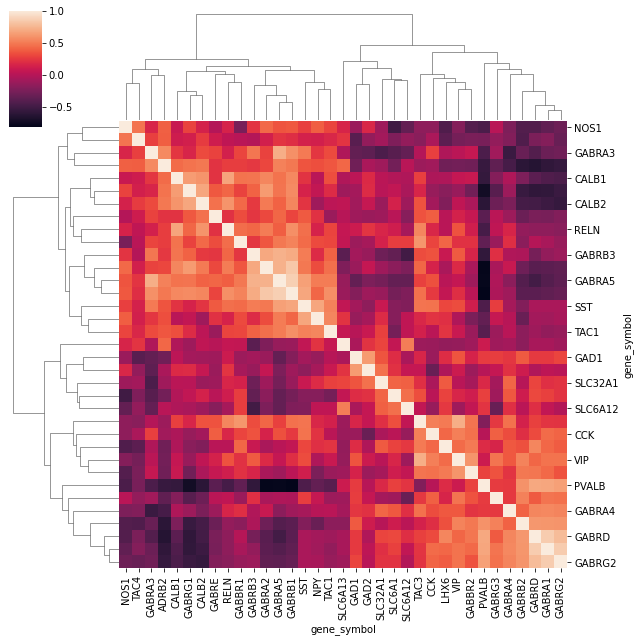

GABA gene cluster 1: ['GABRA2', 'GABRA3', 'GABRA5', 'GABRB1', 'GABRB3', 'GABRG1', 'GABRE', 'SST', 'NPY', 'CALB1', 'CALB2', 'NOS1', 'RELN', 'ADRB2', 'TAC1', 'TAC4', 'GABBR1']
GABA gene cluster 2: ['GABRA1', 'GABRB2', 'GABRG2', 'GABRD', 'PVALB']
GABA gene cluster 3: ['GABRA4', 'GABRG3', 'VIP', 'CCK', 'LHX6', 'TAC3', 'GABBR2']
GABA gene cluster 4: ['GAD1', 'GAD2', 'SLC6A1', 'SLC6A13', 'SLC6A12', 'SLC32A1']


In [33]:
# GABAa-related genes
genes_GABA = ['GABRA1', 'GABRA2', 'GABRA3', 'GABRA4', 'GABRA5', # missing: 'GABRA6'
              'GABRB1', 'GABRB2', 'GABRB3', 
              'GABRG1', 'GABRG2', 'GABRG3',
              'GABRD', 'GABRE', # missing: 'GABRP', 'GABRQ', 'GABRR1', 'GABRR2', 'GABRR3'
              'GAD1', 'GAD2', 
              'PVALB', 'SST', 'VIP', 'CCK', 'NPY', 'CALB1', 'CALB2', 'NOS1', 'RELN', 'ADRB2', 'LHX6', # missing: 'LAMB5'
              'TAC1', 'TAC3', 'TAC4',
              'SLC6A1', 'SLC6A13', 'SLC6A12', 'SLC32A1', # missing: 'SLC6A11'
              'GABBR1', 'GABBR2'
              ]

# get parcel-wise data
mRNA_parcellated_GABA = mRNA_parcellated[genes_GABA].reset_index(drop=True)
# get spearman correlation matrix
mRNA_parcellated_GABA_corr = mRNA_parcellated_GABA.corr(method='spearman')

# distance clustering
mRNA_parcellated_GABA_dist = spc.distance.pdist(mRNA_parcellated_GABA_corr)
mRNA_parcellated_GABA_link = spc.linkage(mRNA_parcellated_GABA_dist, method='complete')
idx = spc.fcluster(mRNA_parcellated_GABA_link, 0.5 * mRNA_parcellated_GABA_dist.max(), 'distance')
genes_GABA_clustered = pd.Series(idx.T, index=mRNA_parcellated_GABA.columns, name='cluster')

# plot cluster-heatmap
clustermap(mRNA_parcellated_GABA_corr, figsize=(9,9))
plt.show()

# get mean for each gene cluster
GABA_mean_list = list()
for cl in range(1, idx.max()+1):
    GABA_cl = genes_GABA_clustered[genes_GABA_clustered==cl].index.tolist() # genes in cluster
    mRNA_parcellated_GABA_cl_tempmean = mRNA_parcellated_GABA[GABA_cl].mean(axis=1)
    GABA_mean_list.append(mRNA_parcellated_GABA_cl_tempmean)
    print(f'GABA gene cluster {cl}: {GABA_cl}')
mRNA_parcellated_GABA_means = pd.DataFrame(GABA_mean_list, index=['GABAcl1', 'GABAcl2', 'GABAcl3', 'GABAcl4']).transpose()

# save data
mRNA_parcellated_GABA.to_csv(join(wd, 'context', 'GABAall_parcellated_data.csv'), index=False)
mRNA_parcellated_GABA_means.to_csv(join(wd, 'context', 'GABAcl_parcellated_data.csv'), index=False)

In [9]:
# JuSpace correlations

# initialize matlab engine
eng = matlab.engine.start_matlab()

# make JuSpace input volumes
GABAcl_files = list()
for map in mRNA_parcellated_GABA_means:
    _, GABAcl_file = parcel_data_to_volume(mRNA_parcellated_GABA_means[map], atlas116, 
                                           save_path=join(wd, 'context', 'parcel_maps', f'{map}.nii.gz'))
    GABAcl_files.append(GABAcl_file)

# run Juspace wrapper function through matlab engine
GABAcl_JuSpace_res_file = eng.juspace_correlations(
    [ale_z.get_filename()],
    GABAcl_files, 
    [atlas116.get_filename()],
    n_perm, 
    join(wd, 'context', 'GABAcl_ale_z_JuSpace.csv')) 
eng.quit()

# get JuSpace result
GABAcl_JuSpace_res = pd.read_csv(GABAcl_JuSpace_res_file) 
# create new table
sig, q = fdrcorrection(GABAcl_JuSpace_res.p_exact)
GABAcl_res = pd.DataFrame({
    'GABAcl': GABAcl_JuSpace_res['PET Map'], 
    'zr': GABAcl_JuSpace_res["Mean Fisher's z (Spearman rho)"], 
    'p': GABAcl_JuSpace_res.p_exact, 
    'q': q, 
    'sig': sig 
})

# save & show 
GABAcl_res.to_csv(join(wd, 'context', 'GABAcl_ale_z_fdr.csv'))
display(GABAcl_res.sort_values(by='zr', ascending=False))

JuSpace: spearman correlations.
Unzipping input volume(s) (if necessary).
Unzipping: /Users/leonlotter/MAsync/project/data/ale/ale_z.nii.gz
Unzipping target volume(s) (if necessary).
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/GABAcl1.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/GABAcl2.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/GABAcl3.nii.gz
Unzipping: /Users/leonlotter/MAsync/project/data/context/parcel_maps/GABAcl4.nii.gz
Unzipping atlas volume (if necessary).
Unzipping: /Users/leonlotter/MAsync/project/data/atlases/Schaefer100-7_TianS1_2mm.nii.gz
Initialising batch system... done.


------------------------------------------------------------------------
13-Apr-2022 20:05:32 - Running job #1
------------------------------------------------------------------------
13-Apr-2022 20:05:32 - Running 'Image Calculator'

SPM12: spm_imcalc (v6961)                          20:05:32 - 13/04/2022
ImCalc I

GABAcl        zr        p        q    sig
1  GABAcl2  0.512272  0.00040  0.00080   True
2  GABAcl3  0.455495  0.00020  0.00080   True
3  GABAcl4 -0.045078  0.63767  0.63767  False
0  GABAcl1 -0.357193  0.12318  0.16424  False

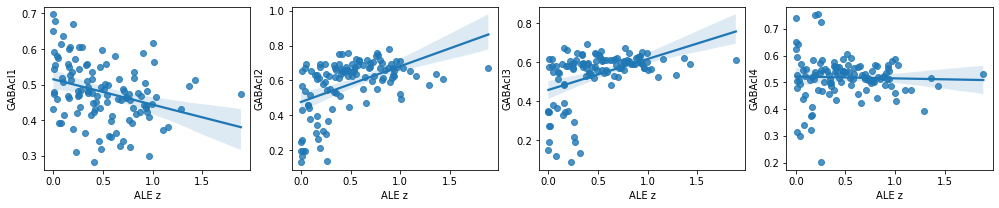

In [34]:
fig, axes = plt.subplots(1,4, figsize=(17,3))
for i, map in enumerate(mRNA_parcellated_GABA_means):
    regplot(x=ale_z_parc, y=mRNA_parcellated_GABA_means[map], ax=axes[i])

## 7 Finished!

[Go back to the top](#The-Neurobiological-Basis-of-Interpersonal-Neural-Synchronization:-Evidence-from-a-Multimodal-Data-Fusion-Approach)

In [1]:
!jupyter nbconvert MAsync_analyses.ipynb --to html

[NbConvertApp] Converting notebook MAsync_analyses.ipynb to html
[NbConvertApp] Writing 6425649 bytes to MAsync_analyses.html
